# Big Data Coursework Part 2

## Data Processing and Machine Learning in the Cloud 

This is **part 2** of the **INM432 Big Data coursework 2020**. 
This extended coursework will **replace the written exam** and contains extended elements of **theory** and as well as **practical components** . 
It will therefore have a **higher weighting** and count for **65% of the module mark**.

## Code and Report

Your tasks are porting, parallelization, extension, evaluation, and theoretical reflection. 
The **coding tasks** are to be completed in (a copy of) **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that your **code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the  **textual answers** as indicated **in a separate PDF document**.  
Include screenshots from the Google Cloud web interface and result tables, as well as written text about the analysis. 


## Submission

Download and submit **the notebook** as an **.ipynb** file and also as a **shareable link** to your notebook (**don’t change the online version after submission**). 

Further, provide a **PDF report document** with answers containing text, plots, screenshots and tables. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  



## Introduction and Description

This part of the coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** the **pre-processing** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains **4 sections**. Section 0 is only about settings and preparations for cloud computing and has no tasks for you (still read the code and comments). 
Section 1 contains tasks about data pre-processing. 
Sections 2 is about machine learning in the cloud. Section 3 contains the theoretical task for discussion. 


### Section 0

This section just contains some necessary code for setting up the environment.

### Section 1 
Section 1 is about reading image files into a dataset and creating TF Record files. 
We will start with an application of some pre-processing steps to a public “Flowers” dataset (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable and you can scale up later. 

In the **Getting Started** we will work through the code from *Fast and Lean Data Science*. There no task for you here, but you should work through this code before you do the rest.

In **Task 1** we are going to **measure the speed of reading data** in the cloud and we will **parallelise this in Spark**, using Google Cloud (GC) Dataproc in **Task 2**. 
For large amounts of training data, the task of creating the TF Record files benefits from parallelisation, which we will also do in Spark in **Task 3**. 

### Section 2

In Section 2, we will **use  pre-processed data** (the public version of the one prepared in Section 1) to train a **deep neural network** in **Tensorflow 2/Keras**. 
We will use transfer learning to take advantage of existing trained models and reduce the training effort. 

We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 4**. 
In contrast to the GC Compute Engine, we can use  machines with GPUs in AI-Platform with free credits. 

### Section 3

This section is about the theoretical discussion, based on to two papers, in **Task 5**. The answers should be given in the PDF report. 

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needing the solution to the earlier ones.

# Section 0: Set-up

You need to run the **imports and authentication every time you work with this notebook**. 
Use the **local Spark** installation **as needed**. 
Read through this once and fill in the project ID the first time, then you can just run straight throught them - except for the two authentication cells - at the beginning of each session.  

### Imports

We import some **packages that will be needed throughout**. 
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below. 

The line `%tensorflow_version 2.x` is specific to Colab and **needs to be removed** (together with the preceding line) **in any cloud code**. 
Colab has recently switched to TF 2.2, while the cloud installations use 2.1, but that has not caused problems so far. 


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.2.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform. 

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW2` to use for this work. 
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive"
!mkdir BD-CW2
%cd "/content/drive/My Drive/BD-CW2"

Mounting google drive...
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive
mkdir: cannot create directory ‘BD-CW2’: File exists
/content/drive/My Drive/BD-CW2


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [0]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to create a new Google Cloud project for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also enable billing and the Storage and Dataproc APIs like we did [during the labs](https://moodle.city.ac.uk/pluginfile.php/1860059/mod_resource/content/4/Google-Cloud-Introduction-v3.pdf).

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [4]:
PROJECT = 'bigdataprojectpabloquinoa' ### USE YOUR PROJECT ID HERE! ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
region = us-central1
[core]
account = pablo.quinoas@gmail.com
project = bigdataprojectpabloquinoa
[dataproc]
region = us-central1

Your active configuration is: [default]


With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409."
**You must create your own bucket to have write access.**

In [5]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://bigdataprojectpabloquinoa-storage/...
ServiceException: 409 Bucket bigdataprojectpabloquinoa-storage already exists.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [0]:
#@title "Display utility functions [RUN THIS TO ACTIVATE]" { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))   
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  

### Install Spark locally for quick testing

You can use the cell below to install a local Spark as in the labs, to do quicker small-scale interactive testing. Using the cloud is still required for the final version. 


In [14]:
# install spark
%cd
!apt-get install openjdk-8-jdk-headless -qq
!wget https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.5-bin-hadoop2.7.tgz > /dev/null
!pip install -q findspark==1.3.0
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()
%cd /content
# get a spark context
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 144467 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u252-b09-1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u252-b09-1~18.04) ...
Selecting previously unselected package openjdk-8-jdk-headless:amd64.
Preparing to unpack .../openjdk-8-jdk-headless_8u252-b09-1~18.04_amd64.deb ...
Unpacking openjdk-8-jdk-headless:amd64 (8u252-b09-1~18.04) ...
Setting up openjdk-8-jre-headless:amd64 (8u252-b09-1~18.04) ...
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/orbd to provide /usr/bin/orbd (orbd) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/servertool to provide /usr/bin/servertool (servertool) in auto mode
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/tnameserv to provide /usr/bin/tnameserv (tnameserv) in auto mode
Setting up openjdk-8-jdk-headless:amd64 (8u

# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

## Getting started 

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.


These are some variables with **settings for the *Flowers* dataset**.

In [0]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
PARTITIONS = 16 # the data will partitioned later
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
    # labels for the data (folder names)

###Read images and labels

We **read the image files** from a public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow**  class has **functions** to process standard **image files**. The `decode_jpeg_and_label` function also extracts the label name from the path. 

In [9]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
partition_size = math.ceil(1.0 * nb_images / PARTITIONS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, PARTITIONS, partition_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=AUTO)
for x in dataset1.take(1):
    print(x) # show what's in a data item

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.
(<tf.Tensor: shape=(240, 192, 3), dtype=uint8, numpy=
array([[[ 42, 142, 238],
        [ 46, 151, 242],
        [ 50, 161, 243],
        ...,
        [ 68, 181, 241],
        [ 70, 183, 239],
        [ 72, 186, 240]],

       [[ 47, 151, 240],
        [ 51, 155, 240],
        [ 55, 162, 242],
        ...,
        [ 69, 181, 244],
        [ 71, 184, 242],
        [ 72, 185, 241]],

       [[ 51, 158, 240],
        [ 54, 159, 240],
        [ 55, 161, 239],
        ...,
        [ 66, 178, 242],
        [ 65, 177, 240],
        [ 65, 177, 240]],

       ...,

       [[138, 178,  20],
        [136, 182,  24],
        [123, 176,  23],
        ...,
        [161, 209, 110],
        [188, 229, 150],
        [199, 227, 179]],

       [[128, 176,  12],
        [134, 181,  25],
        [135, 182,  40],
        ...,
        [117, 174,  79],
        [125, 180,  96],
        [137, 188, 119]],

       [[

Now we can **have a look** at the images with one of the display functions. Note the **different aspect ratios**.

In [10]:
display_9_images_from_dataset

<function __main__.display_9_images_from_dataset>

### Resize and crop images to common size

Standard Neural Networks, like most machine learning algorithms, need **fixed size input items**. 
We achieve this here by resizing and cropping the images to a common target resolution.

In [0]:
def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

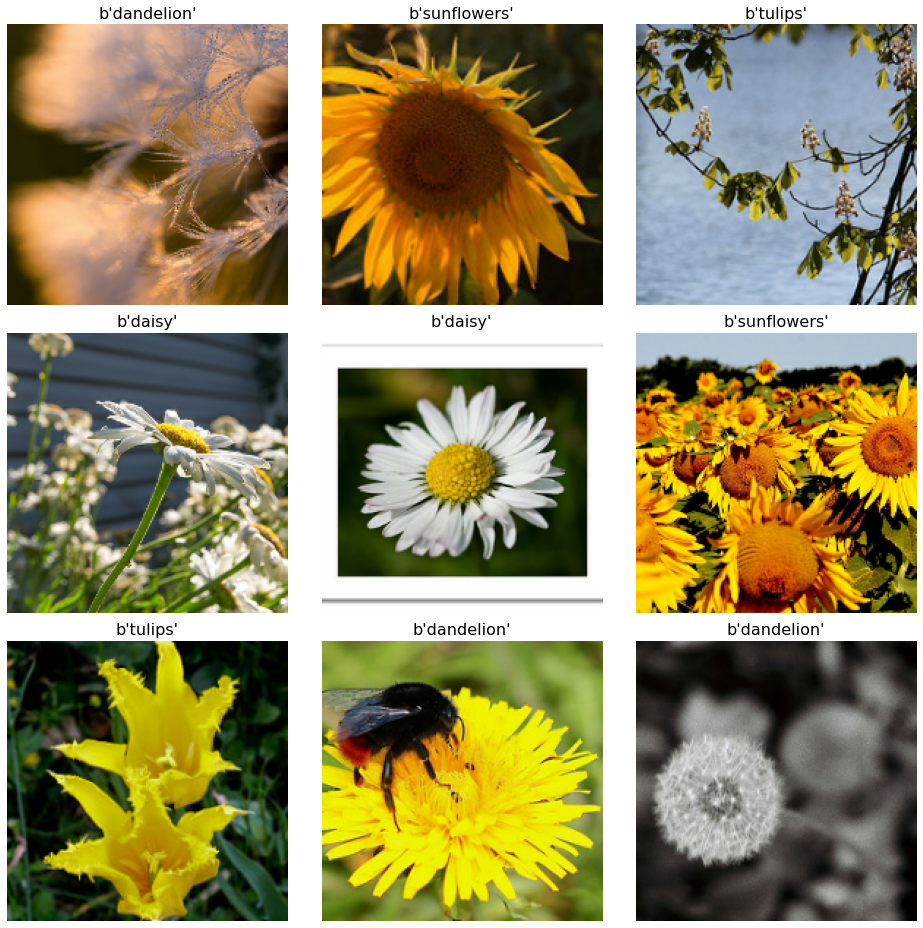

In [12]:
display_9_images_from_dataset(dataset2)

Now test continuous reading from the dataset.

In [13]:
batched_dataset = dataset2.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['sunflowers', 'roses', 'daisy', 'dandelion', 'tulips', 'tulips', 'tulips', 'roses'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'sunflowers', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'dandelion', 'daisy'])
Image batch shape (8, 192, 192, 3), ['daisy', 'roses', 'sunflowers', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'tulips'])
Image batch shape (8, 192, 192, 3), ['tulips', 'tulips', 'dandelion', 'sunflowers', 'daisy', 'tulips', 'tulips', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['roses', 'dandelion', 'sunflowers', 'tulips', 'tulips', 'daisy', 'dandelion', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'dandelion', 'daisy', 'roses', 'tulips', 'roses', 'roses', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['tulips', 'dandelion', 'dandelion', 'daisy', 'tulips', 'tulips', 'dandelion', 'roses'])
Image batch shape (8, 192, 192, 3), ['tulips', 'sunflowers', 'daisy', 'dandelion', 'daisy', 'dandelion', 'dandeli

## Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read mutliple times**. 


In [0]:
def recompress_image(image, label):
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file 

In [0]:
# This is a quick test to get an idea how long recompressions takes.  

BATCH_SIZE = 8
dataset4 = dataset3.batch(BATCH_SIZE)
BATCH_NUMBER = 3 # number of batches
test_set = dataset4.take(BATCH_NUMBER)
for image, label, height, width in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (8,), ['tulips', 'tulips', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'roses'])
Image batch shape (8,), ['daisy', 'daisy', 'tulips', 'roses', 'dandelion', 'roses', 'sunflowers', 'tulips'])
Image batch shape (8,), ['tulips', 'dandelion', 'sunflowers', 'daisy', 'tulips', 'roses', 'daisy', 'dandelion'])


### Write the dataset to TFRecord files

By writing **multiple samples into a single file**, we can make further speed gains. We distribute the data over a number of so-called **partitions** to facilitate parallelisation when the data are used. 

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use.

First we need to **define a location** where we want to put the file. 


In [0]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. 

In [0]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
tt0 = time.time()
filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
dataset1 = filenames.map(decode_jpeg_and_label)
dataset2 = dataset1.map(resize_and_crop_image)  
dataset3 = dataset2.map(recompress_image)
dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file 
for partition, (image, label, height, width) in enumerate(dataset4):
    # batch size used as partition size here
    partition_size = image.numpy().shape[0]
    # good practice to have the number of records in the filename
    filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
    # You need to change GCS_OUTPUT to your own bucket to actually create new files  
    with tf.io.TFRecordWriter(filename) as out_file:
        for i in range(partition_size):
            example = to_tfrecord(out_file,
                                image.numpy()[i], # re-compressed image: already a byte string
                                label.numpy()[i] #, height.numpy()[i], width.numpy()[i]
                                )
            out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, partition_size))
print("Total time: "+str(time.time()-tt0))

Writing TFRecords
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://bigdataprojectpabloqui

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [0]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecoded = load_dataset(filenames)

In [70]:
datasetDecoded

<MapDataset shapes: ((192, 192, 3), ()), types: (tf.uint8, tf.int64)>

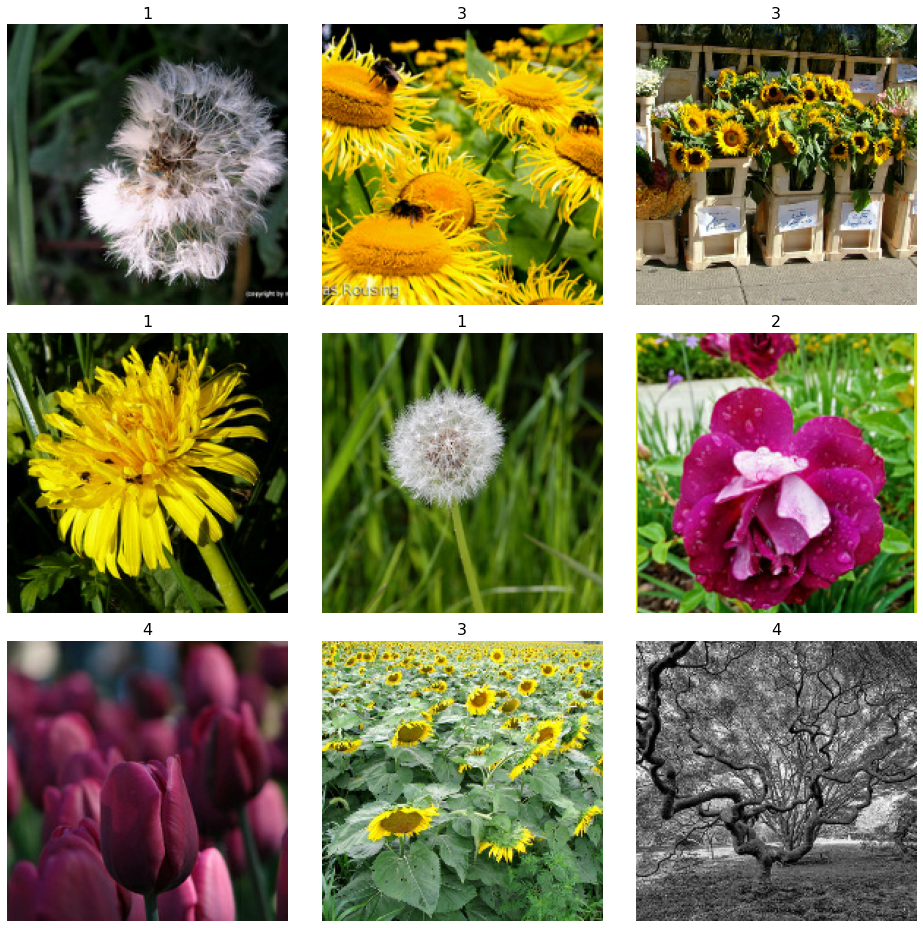

In [71]:
display_9_images_from_dataset(datasetDecoded)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [0]:
batched_dataset = datasetDecoded.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3'])
Image batch shape (8, 192, 192, 3), ['4', '3', '3', '0', '3', '4', '2', '2'])
Image batch shape (8, 192, 192, 3), ['3', '2', '0', '3', '4', '4', '4', '1'])
Image batch shape (8, 192, 192, 3), ['3', '2', '4', '4', '4', '3', '1', '3'])
Image batch shape (8, 192, 192, 3), ['4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (8, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1'])
Image batch shape (8, 192, 192, 3), ['2', '0', '1', '1', '1', '2', '0', '0'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '1', '1', '2', '0', '2'])
Image batch shape (8, 192, 192, 3), ['3', '4', '2', '1', '1', '0', '0', '1'])
Image batch shape (8, 192, 192, 3), ['1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (8, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3'])
Image batch shape (8, 192, 192, 3), ['0', '1', '0', '0', '1', '1', '1', '0'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '2', '2', '1

## Task1: Speed tests (8%)

We have just seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **understanding and quantifying this effect** better. 

### 1a): Speed test implementation (5%)

Start by implementing **code for time measurement** to determine the **throughput in images per second**. 
Don't render the images, just print some basic information in order to **avoid measuring image rendering time**. 
It's useful to write to the null device for longer measurements (e.g. 
`print('string', file=open("/dev/null", mode='w')`).

Use batches ( `dataset.batch(batch_size)` ) and select a sample with (`dataset.take(batch_number)`). 
Good starting values are 8 and 10, i.e. we take 10 batches of 8 samples each. 

Use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset. 

**Vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be packaged into a **function** `time_configs()` that takes a dataset and the batch_sizes, batch_numbers, and number of repetitions as **arguments** to run a series of tests. 



In [0]:
import pandas as pd

def time_configs(dataset,batch_sizes,batch_numbers,repetitions):
    # We create a dataframe: One column for each of the 3 parameters and as many rows as possible combinations
    numpy_data=np.array(np.meshgrid(batch_numbers,np.arange(0,repetitions+1),batch_sizes)).T.reshape(-1,3)
    param_combinations = pd.DataFrame(data=numpy_data, columns=[ "batch_number", "repetition", "batch_size",])
    param_combinations = param_combinations[['batch_size', 'batch_number','repetition']]
    param_combinations['read time'] = np.nan
    i=0 #index of rows in dataframe (for each possible combination among the 3 parameters)

    for batch in batch_sizes:
      for sample in batch_numbers:
        for rep in range(0, repetitions+1):
          batched_dataset = dataset.batch(batch)
          sample_set = batched_dataset.take(sample)
          startTime=time.time()
          for image, label in sample_set:
            print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]), file=open("/dev/null", mode='w'))
          endTime=time.time()
          # store ellapsed time to read all the samples in a batch
          param_combinations.at[i, 'read time'] =(endTime-startTime)
          i=i+1
          #As soon as all the entries are read from the dataset and you try to read the next element, the dataset will throw an error.
          # We use dataset.repeat() to reinitialize the dataset
          dataset=dataset.repeat(1)
    return param_combinations

**Try your function** with a **small number** of configurations of batch_sizes batch_numbers and repetitions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded).


In [0]:
batch_sizes = [2, 4, 8, 16 ] 
batch_numbers = [3, 6 , 20 ,30] 
repetitions = 2 #range from 0 to 2

In [0]:
times_dataset2=time_configs(dataset2,batch_sizes,batch_numbers,repetitions)
print ("Reading from image files: ")
times_dataset2

Reading from image files: 


batch_size  batch_number  repetition  read time
0            2             3           0   0.174809
1            2             3           1   0.182904
2            2             3           2   0.184078
3            2             6           0   0.253948
4            2             6           1   0.263467
5            2             6           2   0.257656
6            2            20           0   0.826460
7            2            20           1   0.800946
8            2            20           2   0.799395
9            2            30           0   1.077266
10           2            30           1   1.084021
11           2            30           2   1.072765
12           4             3           0   0.264690
13           4             3           1   0.250458
14           4             3           2   0.267355
15           4             6           0   0.464768
16           4             6           1   0.460471
17           4             6           2   0.454991
18           4            20           0   1.441895
19           4            20           1   1.440125
20           4            20           2   1.484299
21           4            30           0   2.240195
22           4            30           1   2.142429
23           4            30           2   2.178767
24           8             3           0   0.471005
25           8             3           1   0.471104
26           8             3           2   0.470970
27           8             6           0   0.893192
28           8             6           1   0.903219
29           8             6           2   0.884893
30           8            20           0   2.770306
31           8            20           1   2.793164
32           8            20           2   2.788417
33           8            30           0   4.138168
34           8            30           1   4.202005
35           8            30           2   4.138274
36          16             3           0   0.889693
37          16             3           1   0.908791
38          16             3           2   0.872464
39          16             6           0   1.707410
40          16             6           1   1.727706
41          16             6           2   1.698444
42          16            20           0   5.590908
43          16            20           1   5.567846
44          16            20           2   5.540195
45          16            30           0   8.297147
46          16            30           1   8.351527
47          16            30           2   8.039258

In [0]:
times_datasetDecoded=time_configs(datasetDecoded,batch_sizes,batch_numbers,repetitions)
print ("Reading from TFRecord files: ")
times_datasetDecoded

Reading from TFRecord files: 


batch_size  batch_number  repetition  read time
0            2             3           0   0.060485
1            2             3           1   0.051667
2            2             3           2   0.052084
3            2             6           0   0.056054
4            2             6           1   0.057581
5            2             6           2   0.090889
6            2            20           0   0.073856
7            2            20           1   0.079510
8            2            20           2   0.072898
9            2            30           0   0.086598
10           2            30           1   0.097746
11           2            30           2   0.085881
12           4             3           0   0.054979
13           4             3           1   0.079178
14           4             3           2   0.060554
15           4             6           0   0.064890
16           4             6           1   0.061221
17           4             6           2   0.064052
18           4            20           0   0.102606
19           4            20           1   0.099957
20           4            20           2   0.102219
21           4            30           0   0.128471
22           4            30           1   0.117296
23           4            30           2   0.127385
24           8             3           0   0.060956
25           8             3           1   0.061008
26           8             3           2   0.068311
27           8             6           0   0.075293
28           8             6           1   0.078398
29           8             6           2   0.086449
30           8            20           0   0.151588
31           8            20           1   0.141757
32           8            20           2   0.139438
33           8            30           0   0.263021
34           8            30           1   0.256853
35           8            30           2   0.263580
36          16             3           0   0.079186
37          16             3           1   0.079220
38          16             3           2   0.085840
39          16             6           0   0.105960
40          16             6           1   0.106807
41          16             6           2   0.109353
42          16            20           0   0.296033
43          16            20           1   0.302495
44          16            20           2   0.305135
45          16            30           0   0.475599
46          16            30           1   0.473967
47          16            30           2   0.457724

### 1b) Speed test analysis (3%)

Do a **linear regression** over pre-processing and reading **speed** as a **function of parameters**. Look at the parameters `batch_size`, `batch_number`, `repetition` and the dataset size (`batch_size * batch_number`). 

**Print** the regression results (slope, intercept, pvalue etc) and **plot** the measurements and the regression line for each of the 4 parameters. 


# **Image files:**

In [0]:
# linear regression of reading speed from image files as a function of 
# the parameters batch_size, batch_number, repetition and the dataset size (batch_size * batch_number)
import statsmodels.api as sm
# we add the new parameter dataset size as a new column of the dataframe: dataset size (batch_size * batch_number).
times_dataset2['dataset size'] = times_dataset2.batch_size * times_dataset2.batch_number
times_dataset2 = times_dataset2[['batch_size', 'batch_number','repetition','dataset size','read time']]

X = times_dataset2[['batch_size', 'batch_number','repetition','dataset size']] 
Y = times_dataset2['read time']

modeldataset2 = sm.OLS(Y, X).fit()
predictionsdataset2 = modeldataset2.predict(X) 

print_modeldataset2 = modeldataset2.summary()
print(print_modeldataset2)

                                 OLS Regression Results                                
Dep. Variable:              read time   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.014e+04
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    9.77e-78
Time:                        23:19:30   Log-Likelihood:                          77.108
No. Observations:                  48   AIC:                                     -146.2
Df Residuals:                      44   BIC:                                     -138.7
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


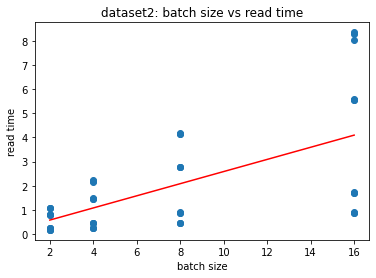

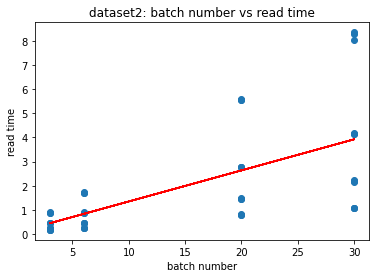

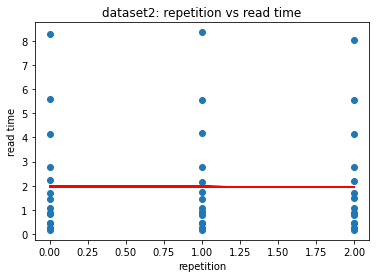

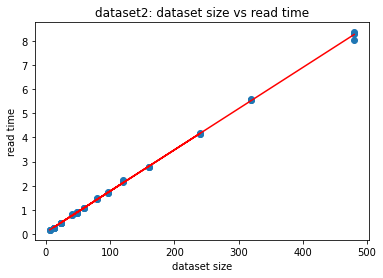

In [0]:
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['batch_size'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['batch_size'].values.reshape(-1,1))  # make predictions
plt.scatter(X['batch_size'].values.reshape(-1,1), Y)
plt.plot(X['batch_size'].values.reshape(-1,1), Y_pred, color='red')
plt.title("dataset2: batch size vs read time")
plt.xlabel("batch size")
plt.ylabel("read time")
plt.show()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['batch_number'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['batch_number'].values.reshape(-1,1))  # make predictions
plt.scatter(X['batch_number'].values.reshape(-1,1), Y)
plt.plot(X['batch_number'].values.reshape(-1,1), Y_pred, color='red')
plt.title("dataset2: batch number vs read time")
plt.xlabel("batch number")
plt.ylabel("read time")
plt.show()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['repetition'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['repetition'].values.reshape(-1,1))  # make predictions
plt.scatter(X['repetition'].values.reshape(-1,1), Y)
plt.plot(X['repetition'].values.reshape(-1,1), Y_pred, color='red')
plt.title("dataset2: repetition vs read time")
plt.xlabel("repetition")
plt.ylabel("read time")
plt.show()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['dataset size'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['dataset size'].values.reshape(-1,1))  # make predictions
plt.scatter(X['dataset size'].values.reshape(-1,1), Y)
plt.plot(X['dataset size'].values.reshape(-1,1), Y_pred, color='red')
plt.title("dataset2: dataset size vs read time")
plt.xlabel("dataset size")
plt.ylabel("read time")
plt.show()

# **TFRecord files:**

In [0]:
# linear regression of reading speed from TFRecord files as a function of 
# the parameters batch_size, batch_number, repetition and the dataset size (batch_size * batch_number)
# we add the new parameter dataset size as a new column of the dataframe: dataset size (batch_size * batch_number).
times_datasetDecoded['dataset size'] = times_datasetDecoded.batch_size * times_datasetDecoded.batch_number
times_datasetDecoded = times_datasetDecoded[['batch_size', 'batch_number','repetition','dataset size','read time']]

X = times_datasetDecoded[['batch_size', 'batch_number','repetition','dataset size']] 
Y = times_datasetDecoded['read time']
modelDatasetDecoded = sm.OLS(Y, X).fit()
predictionsDatasetDecoded = modelDatasetDecoded.predict(X) 

print_modelDatasetDecoded = modelDatasetDecoded.summary()
print(print_modelDatasetDecoded)

                                 OLS Regression Results                                
Dep. Variable:              read time   R-squared (uncentered):                   0.983
Model:                            OLS   Adj. R-squared (uncentered):              0.982
Method:                 Least Squares   F-statistic:                              640.6
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    2.28e-38
Time:                        23:27:09   Log-Likelihood:                          113.78
No. Observations:                  48   AIC:                                     -219.6
Df Residuals:                      44   BIC:                                     -212.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

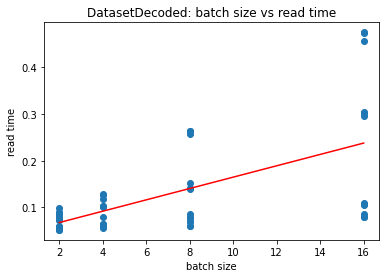

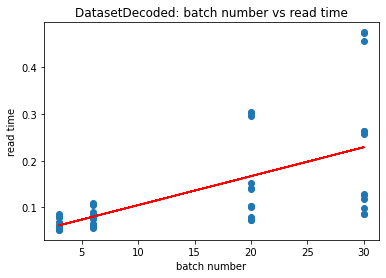

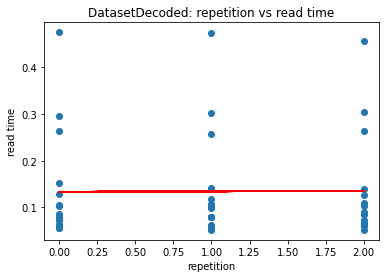

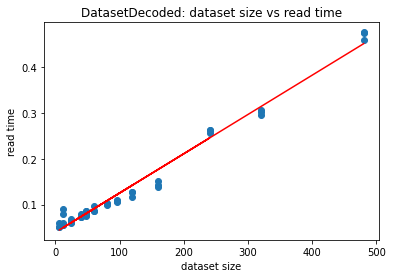

In [0]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['batch_size'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['batch_size'].values.reshape(-1,1))  # make predictions
plt.scatter(X['batch_size'].values.reshape(-1,1), Y)
plt.plot(X['batch_size'].values.reshape(-1,1), Y_pred, color='red')
plt.title("DatasetDecoded: batch size vs read time")
plt.xlabel("batch size")
plt.ylabel("read time")
plt.show()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['batch_number'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['batch_number'].values.reshape(-1,1))  # make predictions
plt.scatter(X['batch_number'].values.reshape(-1,1), Y)
plt.plot(X['batch_number'].values.reshape(-1,1), Y_pred, color='red')
plt.title("DatasetDecoded: batch number vs read time")
plt.xlabel("batch number")
plt.ylabel("read time")
plt.show()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['repetition'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['repetition'].values.reshape(-1,1))  # make predictions
plt.scatter(X['repetition'].values.reshape(-1,1), Y)
plt.plot(X['repetition'].values.reshape(-1,1), Y_pred, color='red')
plt.title("DatasetDecoded: repetition vs read time")
plt.xlabel("repetition")
plt.ylabel("read time")
plt.show()

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X['dataset size'].values.reshape(-1,1),Y)  # perform linear regression
Y_pred = linear_regressor.predict(X['dataset size'].values.reshape(-1,1))  # make predictions
plt.scatter(X['dataset size'].values.reshape(-1,1), Y)
plt.plot(X['dataset size'].values.reshape(-1,1), Y_pred, color='red')
plt.title("DatasetDecoded: dataset size vs read time")
plt.xlabel("dataset size")
plt.ylabel("read time")
plt.show()

## Task 2: Parallelising the speed test with Spark in the cloud. (32%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### Preparation: Running Spark in the cloud 

In order to test multiple configurations, especially with reasonably large datasets, we will use **Spark** to run **multiple tests in parallel**. 
We will start by looking at **how to use Spark on GCS Dataproc**. 

This section shows you in detail **how to run Python code in Dataproc**. 
You may need to **enable the Dataproc API** on the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/), if you have not done so, yet. 

First we need to **create a cluster**. We start with a single machine, just to try it out. 

We are using the `gcloud dataproc clusters` command. [Click here for documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/clusters). 
The **parameter** `--image-version 1.4-ubuntu18` makes sure we get **intended software**. 

Starting a cluster **can take a few minutes**. You can wait for the cell to finish processing or interrupt its execution and check on the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/) if the cluster is ready.



In [0]:
!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s 

Waiting on operation [projects/bigdataprojectpabloquinoa/regions/us-central1/operations/e5029beb-df86-354a-932e-76128e6d6f5b].
Created [https://dataproc.googleapis.com/v1/projects/bigdataprojectpabloquinoa/regions/us-central1/clusters/bigdataprojectpabloquinoa-cluster] Cluster placed in zone [us-central1-c].


The `--max-idle 3600s` flag means that the cluster will be **deleted automatically** once it has been **idle for 1 hour**. This helps minimising costs for a cluster left running by accident. 

This is a single-node cluster. This is created a bit more quickly than a multi-node cluster, but set-up is still quite slow (several minutes) because of the **restrictions on the free tier**. 
You **can switch to paid tier** and still use your free credit, but then you **may use up your free credit more quickly** and have to **pay for usage**.
If you stay in the free tier Google promises not to charge you. The free tier resources are sufficient for this coursework, if you use the local Spark installation for testing and set parameters with care. All the development of this coursework was done with a free tier account. 

We have not specified the region (we could have used `--region $REGION`) as we set already the default for Dataproc in the beginning. 

You can run the **command below to get extensive information** about your running cluster. 
However, it is usually **more practical** to look at the [console Dataproc page](https://console.cloud.google.com/dataproc/clusters/). 
You can check the details and current state of your cluster by clicking on its name. 
Double-check there at the end of your working session to make sure that no clusters are left running, especially when you are not in free mode any more. 

In [0]:
!gcloud dataproc clusters describe $CLUSTER 

clusterName: bigdataprojectpabloquinoa-cluster
clusterUuid: d363314a-a095-45b3-b09c-2debbec73043
config:
  configBucket: bigdataprojectpabloquinoa-storage
  gceClusterConfig:
    networkUri: https://www.googleapis.com/compute/v1/projects/bigdataprojectpabloquinoa/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/bigdataprojectpabloquinoa/zones/us-central1-c
  lifecycleConfig:
    idleDeleteTtl: 3600s
    idleStartTime: '2020-05-24T14:30:44.327Z'
  masterConfig:
    diskConfig:
      bootDiskSizeGb: 100
      bootDiskType: pd-ssd
    ima

Now that our cluster is running, we can **submit a Spark job**. 
A minimal Spark job is just a Python script. 
A **simple** "Hello World" Spark **script** is provided in a public cloud bucket. 
Let's **have a look**:

In [0]:
!gsutil cat gs://dataproc-examples/pyspark/hello-world/hello-world.py 

#!/usr/bin/python
import pyspark
sc = pyspark.SparkContext()
rdd = sc.parallelize(['Hello,', 'world!'])
words = sorted(rdd.collect())
print(words)



... and **run it on the cluster**. We submit the job with the `gcloud dataproc jobs` command ([click here for the documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/jobs)) with the cluster name.


In [0]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    gs://dataproc-examples/pyspark/hello-world/hello-world.py 

Job [238e5da476cf40a6bbc1dd2a9ea09a73] submitted.
Waiting for job output...
20/05/24 14:37:16 INFO org.spark_project.jetty.util.log: Logging initialized @3974ms
20/05/24 14:37:16 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
20/05/24 14:37:16 INFO org.spark_project.jetty.server.Server: Started @4083ms
20/05/24 14:37:16 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@4f992865{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
20/05/24 14:37:16 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
20/05/24 14:37:18 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at bigdataprojectpabloquinoa-cluster-m/10.128.0.3:8032
20/05/24 14:37:18 INFO org.apache.hadoop.ya

The `trackingUrl` shown above will work **only as long as the job is running**. On to the [Dataproc page](https://console.cloud.google.com/dataproc/clusters/), you can click through to your cluster page and from there to your job page to **see details on past jobs later**.

You may get some warnings like this: 
`WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair' ...
or this one:
`WARN org.apache.hadoop.hdfs.DataStreamer: Caught exception`. There was not enough time to research these fully but they don't affect what we do here and can be ignored. 

One issue is that we need to **get output data from the cluster back to the notebook**. 
We can output text through printing into the output stream, but that does not work well for scaling up, for automation or for binary data. 

A better solution is to **pass an argument** to the job, to tell the job on the cluster **where to write the output**. 
This requires a bit of **extra code as shown below** using the **argparse package**.
The example below the **checks if the script runs in Colab** and if that is the case, it does not execute the run function. 
You can also **call `run` with arguments provided directly** for quick testing **with a local spark instance** as below.

In [0]:
%%writefile hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    rdd = sc.parallelize(['Hello,', 'world!'])
    words = sorted(rdd.collect())
    save(words,args.out_bucket,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments when run in Colab 
    runWordCount(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    runWordCount(["--out_bucket", BUCKET, "--out_file", "words.pkl"])

Writing hello-world.py


**Once the code works as intended**, you can write it to the local disk (on your Colab instance). For this, **uncomment the first line with the `%%writefile` magic** and then **re-run the cell**. Note that the [`%%writefile` magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#cellmagic-writefile) always needs to be the first line of the cell, before any comments.

Then **check** that the file **is in the current directory** and **has the right contents** like this:

In [0]:
!pwd
!ls -l hello-world.py
!cat hello-world.py

/content
-rw-r--r-- 1 root root 1408 May 24 14:41 hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the valu

We can now submit the job with an **extra section for application arguments**. It's **started by `--`**, which indicates that all following arguments are to be sent to our Spark application. 

In [0]:
FILENAME = 'words.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./hello-world.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

Job [0567aa6e3a3b436ca631490db43f25bf] submitted.
Waiting for job output...
['--out_bucket', 'gs://bigdataprojectpabloquinoa-storage', '--out_file', 'words.pkl']
20/05/24 14:43:06 INFO org.spark_project.jetty.util.log: Logging initialized @3442ms
20/05/24 14:43:06 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
20/05/24 14:43:06 INFO org.spark_project.jetty.server.Server: Started @3579ms
20/05/24 14:43:06 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@259633d5{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
20/05/24 14:43:07 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
20/05/24 14:43:08 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at bigdatapr

Once the job has finished, we can **use the output** by **copying it from the bucket** and **reading it as a local file**.

In [0]:
# Make sure you are writing to the right directory
%cd "/content/drive/My Drive/BD-CW2"
!gsutil cp $BUCKET/$FILENAME . 
!ls -l
with open(FILENAME,mode='rb') as f:
    words = pickle.load(f) 

print("Content of {} : {}".format(FILENAME,words))

/content/drive/My Drive/BD-CW2
Copying gs://bigdataprojectpabloquinoa-storage/words.pkl...
/ [1 files][   34.0 B/   34.0 B]                                                
Operation completed over 1 objects/34.0 B.                                       
total 1
-rw------- 1 root root 34 May 24 14:44 words.pkl
Content of words.pkl : ['Hello,', 'world!']


At the end of a session we should **delete the cluster**, as it incurs a **cost for the time** it runs.  

In [0]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt,
# we want to make sure it really gets deleted

Waiting on operation [projects/bigdataprojectpabloquinoa/regions/us-central1/operations/bc072532-974f-364b-ac9c-f0ab1c68317d].
Deleted [https://dataproc.googleapis.com/v1/projects/bigdataprojectpabloquinoa/regions/us-central1/clusters/bigdataprojectpabloquinoa-cluster].


### 2a) Create the script (12%)
Your task is now to **port the speed test from Task 1 to Spark** for running it in the cloud in Dataproc. 
**Adapt the preprocessing code** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


**i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)**

In [0]:
import itertools
batch_sizes = [2, 4, 8, 16 ] 
batch_numbers = [3, 6 , 20 ,30] 
repetitions=2 # up to 2 repetitions. So 0,1,2
combinationsCombined = [batch_sizes,batch_numbers,np.arange(repetitions+1)]
all_combinations = list(itertools.product(*combinationsCombined))
sc = pyspark.SparkContext.getOrCreate()
rdd_all_combinations = sc.parallelize(all_combinations)
rddallcombinations=rdd_all_combinations.map(lambda x: (x[0],x[1],x[2],x[0]*x[1])) # We add dataset size as batchsize,batchnumber (batchsize,batchnumber,repetition,datasetsize)
print(rddallcombinations.collect())

[(2, 3, 0, 6), (2, 3, 1, 6), (2, 3, 2, 6), (2, 6, 0, 12), (2, 6, 1, 12), (2, 6, 2, 12), (2, 20, 0, 40), (2, 20, 1, 40), (2, 20, 2, 40), (2, 30, 0, 60), (2, 30, 1, 60), (2, 30, 2, 60), (4, 3, 0, 12), (4, 3, 1, 12), (4, 3, 2, 12), (4, 6, 0, 24), (4, 6, 1, 24), (4, 6, 2, 24), (4, 20, 0, 80), (4, 20, 1, 80), (4, 20, 2, 80), (4, 30, 0, 120), (4, 30, 1, 120), (4, 30, 2, 120), (8, 3, 0, 24), (8, 3, 1, 24), (8, 3, 2, 24), (8, 6, 0, 48), (8, 6, 1, 48), (8, 6, 2, 48), (8, 20, 0, 160), (8, 20, 1, 160), (8, 20, 2, 160), (8, 30, 0, 240), (8, 30, 1, 240), (8, 30, 2, 240), (16, 3, 0, 48), (16, 3, 1, 48), (16, 3, 2, 48), (16, 6, 0, 96), (16, 6, 1, 96), (16, 6, 2, 96), (16, 20, 0, 320), (16, 20, 1, 320), (16, 20, 2, 320), (16, 30, 0, 480), (16, 30, 1, 480), (16, 30, 2, 480)]


**ii) get a Spark context and create the dataset and run timing test for each combination in parallel (2%)**

In [0]:
def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    TARGET_SIZE = [192, 192] # the resolution for the images
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def timingTest(dataset,x):
  for rep in range(0, x[2]+1):
    batched_dataset = dataset.batch(x[0])
    sample_set = batched_dataset.take(x[1])
    startTime=time.time()
    for image, label in sample_set:
      print("Image batch shape {}, {})".format(image.numpy().shape, \
      [str(lbl) for lbl in label.numpy()]), file=open("/dev/null", mode='w'))
    endTime=time.time()
    readSpeed = endTime-startTime # we are only interested in the read speed of the last repetition x[2]
  return (x,readSpeed)
  

def timingTestPlainImages(x):
  # We create the plain images dataset like in task 1
  GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
  filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
  dataset1 = filepathDS.map(decode_jpeg_and_label)
  dataset2 = dataset1.map(resize_and_crop_image)
  return timingTest(dataset2,x)

def timingTestTFRecordFiles(x):
  # We create the TFRecord images dataset
  GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  datasetDecoded = load_dataset(filenames)
  return timingTest(datasetDecoded,x)

**iii) transform the resulting RDD to the structure ( parameter_combination, images_per_second ) and save these values in an array (2%)**

In [0]:
# Plain images
rddCombinationsPlainImgs = rddallcombinations.map(timingTestPlainImages) 

# Tranform the above rddCombinations2 to the structure ( parameter_combination, images_per_second )
def transformReadSpeedToImagesPerSecond(x):
  imgsPerSecond=x[0][3]/x[1] #images_per_second= dataset size/readSpeed
  return (x[0],imgsPerSecond)

rddCombinationsToImgsPerSecondPlainImgs = rddCombinationsPlainImgs.map(transformReadSpeedToImagesPerSecond) 
# We save these results into an array/list
paramsToImagesPeSecondArrayPlainImgs=rddCombinationsToImgsPerSecondPlainImgs.collect()
### TASK 2Ci ###
rddCombinationsToImgsPerSecondPlainImgs.cache() #we cache the RDD result. Cache will ensure that processing done previously is preserved and reused
print(paramsToImagesPeSecondArrayPlainImgs)

[((2, 3, 0, 6), 7.081573737831362), ((2, 3, 1, 6), 10.57743996086076), ((2, 3, 2, 6), 8.865351121933072), ((2, 6, 0, 12), 9.803465361866138), ((2, 6, 1, 12), 10.350330241428509), ((2, 6, 2, 12), 8.971902802874695), ((2, 20, 0, 40), 11.31842314274367), ((2, 20, 1, 40), 12.532352729383847), ((2, 20, 2, 40), 11.485483786829645), ((2, 30, 0, 60), 11.961384127095181), ((2, 30, 1, 60), 13.85873692749224), ((2, 30, 2, 60), 12.967698631173214), ((4, 3, 0, 12), 12.289077094403538), ((4, 3, 1, 12), 15.789409489773767), ((4, 3, 2, 12), 17.479343759474325), ((4, 6, 0, 24), 13.985473145325232), ((4, 6, 1, 24), 14.023916779848573), ((4, 6, 2, 24), 12.459711925940294), ((4, 20, 0, 80), 17.579582421922254), ((4, 20, 1, 80), 18.67648469156339), ((4, 20, 2, 80), 17.750784396396988), ((4, 30, 0, 120), 22.132662166462072), ((4, 30, 1, 120), 22.97513667658937), ((4, 30, 2, 120), 23.189834440231945), ((8, 3, 0, 24), 10.302357643856517), ((8, 3, 1, 24), 10.793472918341141), ((8, 3, 2, 24), 10.731598565641843

In [0]:
# TFRecordFiles
rddCombinationsTFRecordFiles = rddallcombinations.map(timingTestTFRecordFiles) 

rddCombinationsToImgsPerSecondTFRecordFiles = rddCombinationsTFRecordFiles.map(transformReadSpeedToImagesPerSecond) 
# We save these results into an array/list
paramsToImagesPeSecondArrayTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.collect()
### TASK 2Ci ###
rddCombinationsToImgsPerSecondTFRecordFiles.cache() #we cache the RDD result. Cache will ensure that processing done previously is preserved and reused
print(paramsToImagesPeSecondArrayTFRecordFiles)

[((2, 3, 0, 6), 80.18296347039238), ((2, 3, 1, 6), 97.3630771373523), ((2, 3, 2, 6), 97.23592414571195), ((2, 6, 0, 12), 208.74453789877072), ((2, 6, 1, 12), 213.6635238681468), ((2, 6, 2, 12), 142.14405982676672), ((2, 20, 0, 40), 433.09006050843607), ((2, 20, 1, 40), 389.095539037768), ((2, 20, 2, 40), 354.9103586289471), ((2, 30, 0, 60), 182.26911644561872), ((2, 30, 1, 60), 504.64875270714685), ((2, 30, 2, 60), 554.254704348439), ((4, 3, 0, 12), 161.74292297458408), ((4, 3, 1, 12), 125.64850028084628), ((4, 3, 2, 12), 129.66359671381943), ((4, 6, 0, 24), 317.87472369235434), ((4, 6, 1, 24), 284.46807680895256), ((4, 6, 2, 24), 312.6169899565841), ((4, 20, 0, 80), 634.9690599914466), ((4, 20, 1, 80), 693.5227127107679), ((4, 20, 2, 80), 749.994009781044), ((4, 30, 0, 120), 930.432406751838), ((4, 30, 1, 120), 763.0932692919976), ((4, 30, 2, 120), 820.1464254812275), ((8, 3, 0, 24), 239.14554711127056), ((8, 3, 1, 24), 331.3625249353163), ((8, 3, 2, 24), 383.03271614803316), ((8, 6, 

**iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (1%)**

In [0]:
# Plain images
rddBatchSizePlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][0],x[1]))
print(rddBatchSizePlainImgs.collect())
rddBatchNumberPlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][1],x[1]))
print(rddBatchNumberPlainImgs.collect())
rddRepetitionPlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][2],x[1]))
print(rddRepetitionPlainImgs.collect())
rddDatasetSizePlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][3],x[1]))
print(rddDatasetSizePlainImgs.collect())

[(2, 25.457747996273266), (2, 39.01436190003721), (2, 30.795145869865554), (2, 28.65250426528629), (2, 20.23142903655647), (2, 30.30263593595534), (2, 36.011001705547685), (2, 40.281276230391434), (2, 36.6954606875657), (2, 41.08347778332469), (2, 37.750846272306624), (2, 32.01187777956146), (4, 32.720176564851506), (4, 33.053951108285744), (4, 31.18024353618103), (4, 32.34895883210778), (4, 32.01051167124316), (4, 30.43958019792639), (4, 32.71738390665535), (4, 33.70891659385799), (4, 36.623783388729265), (4, 32.26498758322642), (4, 37.473296962171375), (4, 38.66754155549056), (8, 34.967528089302185), (8, 41.85208147625826), (8, 44.03364749914044), (8, 38.292846232019436), (8, 33.22082844079751), (8, 38.09956392832021), (8, 37.95757096392935), (8, 41.839487269009204), (8, 41.18324263477308), (8, 38.40912521483757), (8, 39.92578156838613), (8, 48.982653477564504), (16, 44.6872366536988), (16, 49.35216786247542), (16, 51.253754293494254), (16, 55.64761607166179), (16, 51.509522694137175

In [0]:
# TFRecordFiles
rddBatchSizeTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][0],x[1]))
print(rddBatchSizeTFRecordFiles.collect())
rddBatchNumberTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][1],x[1]))
print(rddBatchNumberTFRecordFiles.collect())
rddRepetitionTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][2],x[1]))
print(rddRepetitionTFRecordFiles.collect())
rddDatasetSizeTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][3],x[1]))
print(rddDatasetSizeTFRecordFiles.collect())

[(2, 74.95159950083541), (2, 56.66293804544595), (2, 93.37171224719226), (2, 183.1873778457171), (2, 151.20057678442683), (2, 169.54560704974028), (2, 417.0345365873059), (2, 457.8009899747322), (2, 450.64669667895095), (2, 482.8077714829474), (2, 574.9665061275966), (2, 496.13443787728835), (4, 184.20914171525192), (4, 184.19094042992336), (4, 128.83318785787603), (4, 237.04054235436237), (4, 240.0231192923055), (4, 315.2683608210615), (4, 584.8501464982475), (4, 613.3491753325449), (4, 527.2728586985388), (4, 775.3851842037965), (4, 680.2070421355072), (4, 681.2049882116011), (8, 72.43626127147165), (8, 282.1193741224346), (8, 297.8115913730363), (8, 479.2440513030479), (8, 446.1313620166995), (8, 435.9133744722312), (8, 805.0149525871634), (8, 1088.569004699207), (8, 1062.1129616059686), (8, 381.99910366348143), (8, 743.2371473504677), (8, 770.2595581061693), (16, 447.0099847907901), (16, 447.0129623297556), (16, 444.0492293576363), (16, 731.0307224737746), (16, 682.1496973424071), 

**v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)**

In [0]:
# Plain images
# We compute the average by key for each of the 4 parameters
batchSizeAveragePlainImgs = rddBatchSizePlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(batchSizeAveragePlainImgs)
batchNumberAveragePlainImgs = rddBatchNumberPlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(batchNumberAveragePlainImgs)
repetitionsAveragePlainImgs = rddRepetitionPlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(repetitionsAveragePlainImgs)
datasetSizeAveragePlainImgs = rddDatasetSizePlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(datasetSizeAveragePlainImgs)

[(2, 33.190647121889306), (16, 52.634257491834084), (4, 33.60077765839389), (8, 39.89702973286149)]
[(6, 37.185070658096585), (30, 42.46034040344491), (20, 41.47996403928196), (3, 38.19733690415531)]
[(2, 40.86784853100718), (0, 38.68705733396091), (1, 39.93712813876598)]
[(96, 54.2073297856488), (80, 34.35002796308087), (160, 40.32676695590388), (320, 53.58048169697482), (240, 42.43918675359607), (6, 31.755751922058675), (60, 36.948733945064255), (120, 36.13527536696278), (24, 35.9420512943297), (40, 37.66257954116828), (480, 54.31816554815652), (48, 42.48439956846761), (12, 29.356823407852726)]


In [0]:
# TFRecordFiles
# We compute the average by key for each of the 4 parameters
batchSizeAverageTFRecordFiles = rddBatchSizeTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(batchSizeAverageTFRecordFiles)
batchNumberAverageTFRecordFiles = rddBatchNumberTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(batchNumberAverageTFRecordFiles)
repetitionsAverageTFRecordFiles = rddRepetitionTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(repetitionsAverageTFRecordFiles)
datasetSizeAverageTFRecordFiles = rddDatasetSizeTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
print(datasetSizeAverageTFRecordFiles)

[(4, 429.319557295918), (16, 702.5063983560791), (8, 572.0707285476149), (2, 300.6925625168483)]
[(30, 682.2621670017284), (20, 700.893743022205), (6, 395.3784264390563), (3, 226.05491025347078)]
[(0, 458.4594945053018), (2, 518.8403233783724), (1, 526.142117153671)]
[(480, 866.9814216206281), (240, 631.8319363733727), (12, 166.8611386138226), (96, 695.6622484430278), (160, 985.2323062974464), (40, 441.82740774699636), (60, 517.9695718292775), (120, 712.2657381836349), (24, 240.78320820577866), (320, 801.3578645346001), (48, 449.8934940450268), (80, 575.1573935097771), (6, 74.99541659782454)]


**vi) write the results to a pickle file in your bucket (1%)**

In [0]:
def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

In [0]:
# Plain images
save(batchSizeAveragePlainImgs,BUCKET,"batchSizeAveragePlainImgs.pkl")
save(batchNumberAveragePlainImgs,BUCKET,"batchNumberAveragePlainImgs.pkl")
save(repetitionsAveragePlainImgs,BUCKET,"repetitionsAveragePlainImgs.pkl")
save(datasetSizeAveragePlainImgs,BUCKET,"datasetSizeAveragePlainImgs.pkl")

Saving batchSizeAveragePlainImgs.pkl to gs://bigdataprojectpabloquinoa-storage
gstuil returned: 0
b'Copying file://batchSizeAveragePlainImgs.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   64.0 B]                                                \r/ [1 files][   64.0 B/   64.0 B]                                                \r\nOperation completed over 1 objects/64.0 B.                                       \n'
Saving batchNumberAveragePlainImgs.pkl to gs://bigdataprojectpabloquinoa-storage
gstuil returned: 0
b'Copying file://batchNumberAveragePlainImgs.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   64.0 B]                                                \r/ [1 files][   64.0 B/   64.0 B]                                                \r\nOperation completed over 1 objects/64.0 B.                                       \n'
Saving repetitionsAveragePlainImgs.pkl to gs://bigdataprojectpabloquinoa-storage
gstuil returned: 0
b'Copying file:/

In [0]:
# TFRecordFiles
save(batchSizeAverageTFRecordFiles,BUCKET,"batchSizeAverageTFRecordFiles.pkl")
save(batchNumberAverageTFRecordFiles,BUCKET,"batchNumberAverageTFRecordFiles.pkl")
save(repetitionsAverageTFRecordFiles,BUCKET,"repetitionsAverageTFRecordFiles.pkl")
save(datasetSizeAverageTFRecordFiles,BUCKET,"datasetSizeAverageTFRecordFiles.pkl")

Saving batchSizeAverageTFRecordFiles.pkl to gs://bigdataprojectpabloquinoa-storage
gstuil returned: 0
b'Copying file://batchSizeAverageTFRecordFiles.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   64.0 B]                                                \r/ [1 files][   64.0 B/   64.0 B]                                                \r\nOperation completed over 1 objects/64.0 B.                                       \n'
Saving batchNumberAverageTFRecordFiles.pkl to gs://bigdataprojectpabloquinoa-storage
gstuil returned: 0
b'Copying file://batchNumberAverageTFRecordFiles.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   64.0 B]                                                \r/ [1 files][   64.0 B/   64.0 B]                                                \r\nOperation completed over 1 objects/64.0 B.                                       \n'
Saving repetitionsAverageTFRecordFiles.pkl to gs://bigdataprojectpabloquinoa-storage
gstuil returned

**vii) Write your code it into a file using the cell magic %%writefile spark_job.py (1%)**

**Plain images in one script spark-jobPlainImages.py**

In [0]:
%%writefile spark-PlainImages.py
#combine previous cells into this cell to write all into spark-jobPlainImages.py

import pyspark
import pickle
import itertools
import numpy as np 
import tensorflow as tf
import time
import datetime

PROJECT = 'bigdataprojectpabloquinoa'
BUCKET = 'gs://{}-storage'.format(PROJECT) 

batch_sizes = [2, 4, 8, 16 ] 
batch_numbers = [3, 6 , 20 ,30] 
repetitions=2 # up to 2 repetitions. So 0,1,2
combinationsCombined = [batch_sizes,batch_numbers,np.arange(repetitions+1)]
all_combinations = list(itertools.product(*combinationsCombined))
sc = pyspark.SparkContext.getOrCreate()

### TASK 2cii ###
rdd_all_combinations = sc.parallelize(all_combinations,numSlices=7) # We add parameter numSlices=7 to paralelize work across the 7 workers
rddallcombinations=rdd_all_combinations.map(lambda x: (x[0],x[1],x[2],x[0]*x[1])) # We add dataset size as batchsize,batchnumber (batchsize,batchnumber,repetition,datasetsize)

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    TARGET_SIZE = [192, 192] # the resolution for the images
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
  

def timingTest(dataset,x):
  for rep in range(0, x[2]+1):
    batched_dataset = dataset.batch(x[0])
    sample_set = batched_dataset.take(x[1])
    startTime=time.time()
    for image, label in sample_set:
      print("Image batch shape {}, {})".format(image.numpy().shape, \
      [str(lbl) for lbl in label.numpy()]), file=open("/dev/null", mode='w'))
    endTime=time.time()
    readSpeed = endTime-startTime # we are only interested in the read speed of the last repetition x[2]
  return (x,readSpeed)
  

def timingTestPlainImages(x):
  # We create the plain images dataset like in task 1
  GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
  filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
  dataset1 = filepathDS.map(decode_jpeg_and_label)
  dataset2 = dataset1.map(resize_and_crop_image)
  return timingTest(dataset2,x)

rddCombinationsPlainImgs = rddallcombinations.map(timingTestPlainImages) 

# Tranform the above rddCombinations2 to the structure ( parameter_combination, images_per_second )
def transformReadSpeedToImagesPerSecond(x):
  imgsPerSecond=x[0][3]/x[1] #images_per_second= dataset size/readSpeed
  return (x[0],imgsPerSecond)

rddCombinationsToImgsPerSecondPlainImgs = rddCombinationsPlainImgs.map(transformReadSpeedToImagesPerSecond) 
# We save these results into an array/list
paramsToImagesPeSecondArrayPlainImgs=rddCombinationsToImgsPerSecondPlainImgs.collect()

### TASK 2Ci ###
rddCombinationsToImgsPerSecondPlainImgs.cache() #we cache the RDD result. Cache will ensure that processing done previously is preserved and reused

rddBatchSizePlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][0],x[1]))
rddBatchNumberPlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][1],x[1]))
rddRepetitionPlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][2],x[1]))
rddDatasetSizePlainImgs=rddCombinationsToImgsPerSecondPlainImgs.map(lambda x: (x[0][3],x[1]))

# We compute the average by key for each of the 4 parameters
batchSizeAveragePlainImgs = rddBatchSizePlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
batchNumberAveragePlainImgs = rddBatchNumberPlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
repetitionsAveragePlainImgs = rddRepetitionPlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
datasetSizeAveragePlainImgs = rddDatasetSizePlainImgs.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()

def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

#save raw points (parameter,imagesPerSecond)
save(rddBatchSizePlainImgs.collect(),BUCKET,"batchSizeRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl")
save(rddBatchNumberPlainImgs.collect(),BUCKET,"batchNumberRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl")
save(rddRepetitionPlainImgs.collect(),BUCKET,"repetitionsRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl")
save(rddDatasetSizePlainImgs.collect(),BUCKET,"datasetSizeRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl")
# save averages (parameter,imagesPerSecond)
batchsizeFileNamePlainImgs="batchSizeAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl"
batchnumberFileNamePlainImgs="batchNumberAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl"
repetitionsFileNamePlainImgs="repetitionsAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl"
datasetSizeFileNamePlainImgs="datasetSizeAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"PlainImgs.pkl"
save(batchSizeAveragePlainImgs,BUCKET,batchsizeFileNamePlainImgs)
save(batchNumberAveragePlainImgs,BUCKET,batchnumberFileNamePlainImgs)
save(repetitionsAveragePlainImgs,BUCKET,repetitionsFileNamePlainImgs)
save(datasetSizeAveragePlainImgs,BUCKET,datasetSizeFileNamePlainImgs)


Overwriting spark-PlainImages.py


TFRecordFiles in another script spark-jobTFRecordFiles.py

In [0]:
%%writefile spark-jobTFRecordFiles.py
#combine previous cells into this cell to write all into spark-jobTFRecordFiles.py

import pyspark
import pickle
import itertools
import numpy as np 
import tensorflow as tf
import time
import datetime

PROJECT = 'bigdataprojectpabloquinoa'
BUCKET = 'gs://{}-storage'.format(PROJECT) 
TARGET_SIZE = [192, 192] # the resolution for the images

batch_sizes = [2, 4, 8, 16 ] 
batch_numbers = [3, 6 , 20 ,30] 
repetitions=2 # up to 2 repetitions. So 0,1,2
combinationsCombined = [batch_sizes,batch_numbers,np.arange(repetitions+1)]
all_combinations = list(itertools.product(*combinationsCombined))
sc = pyspark.SparkContext.getOrCreate()
### TASK 2cii ###
rdd_all_combinations = sc.parallelize(all_combinations,numSlices=7) # We add parameter numSlices=7 to paralelize work across the 7 workers
rddallcombinations=rdd_all_combinations.map(lambda x: (x[0],x[1],x[2],x[0]*x[1])) # We add dataset size as batchsize,batchnumber (batchsize,batchnumber,repetition,datasetsize)

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def timingTest(dataset,x):
  for rep in range(0, x[2]+1):
    batched_dataset = dataset.batch(x[0])
    sample_set = batched_dataset.take(x[1])
    startTime=time.time()
    for image, label in sample_set:
      print("Image batch shape {}, {})".format(image.numpy().shape, \
      [str(lbl) for lbl in label.numpy()]), file=open("/dev/null", mode='w'))
    endTime=time.time()
    readSpeed = endTime-startTime # we are only interested in the read speed of the last repetition x[2]
  return (x,readSpeed)

def timingTestTFRecordFiles(x):
  # We create the TFRecord images dataset
  GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  datasetDecoded = load_dataset(filenames)
  return timingTest(datasetDecoded,x)

rddCombinationsTFRecordFiles = rddallcombinations.map(timingTestTFRecordFiles) 

# Tranform the above rddCombinations2 to the structure ( parameter_combination, images_per_second )
def transformReadSpeedToImagesPerSecond(x):
  imgsPerSecond=x[0][3]/x[1] #images_per_second= dataset size/readSpeed
  return (x[0],imgsPerSecond)

rddCombinationsToImgsPerSecondTFRecordFiles = rddCombinationsTFRecordFiles.map(transformReadSpeedToImagesPerSecond) 
# We save these results into an array/list
paramsToImagesPeSecondArrayTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.collect()
### TASK 2Ci ###
rddCombinationsToImgsPerSecondTFRecordFiles.cache() #we cache the RDD result. Cache will ensure that processing done previously is preserved and reused

rddBatchSizeTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][0],x[1]))
rddBatchNumberTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][1],x[1]))
rddRepetitionTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][2],x[1]))
rddDatasetSizeTFRecordFiles=rddCombinationsToImgsPerSecondTFRecordFiles.map(lambda x: (x[0][3],x[1]))

# We compute the average by key for each of the 4 parameters
batchSizeAverageTFRecordFiles = rddBatchSizeTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
batchNumberAverageTFRecordFiles = rddBatchNumberTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
repetitionsAverageTFRecordFiles = rddRepetitionTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()
datasetSizeAverageTFRecordFiles = rddDatasetSizeTFRecordFiles.mapValues(lambda v: (v, 1)).reduceByKey(lambda a,b: (a[0]+b[0], a[1]+b[1])).mapValues(lambda v: v[0]/v[1]).collect()

def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

#save raw points (parameter,imagesPerSecond)
save(rddBatchSizeTFRecordFiles.collect(),BUCKET,"batchSizeRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl")
save(rddBatchNumberTFRecordFiles.collect(),BUCKET,"batchNumberRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl")
save(rddRepetitionTFRecordFiles.collect(),BUCKET,"repetitionsRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl")
save(rddDatasetSizeTFRecordFiles.collect(),BUCKET,"datasetSizeRawPoints_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl")
# save averages (parameter,imagesPerSecond)
batchsizeFileNameTFRecordFiles="batchSizeAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl"
batchnumberFileNameTFRecordFiles="batchNumberAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl"
repetitionsFileNameTFRecordFiles="repetitionsAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl"
datasetSizeFileNameTFRecordFiles="datasetSizeAverage_"+datetime.datetime.now().strftime("%y%m%d-%H%M")+"TFRecordFiles.pkl"
save(batchSizeAverageTFRecordFiles,BUCKET,batchsizeFileNameTFRecordFiles)
save(batchNumberAverageTFRecordFiles,BUCKET,batchnumberFileNameTFRecordFiles)
save(repetitionsAverageTFRecordFiles,BUCKET,repetitionsFileNameTFRecordFiles)
save(datasetSizeAverageTFRecordFiles,BUCKET,datasetSizeFileNameTFRecordFiles)

Overwriting spark-jobTFRecordFiles.py


### 2b) Set up a cluster and run the script. (4%)

In the free credit tier on Google Cloud, there are the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk* 
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.   

The **largest possible cluster** within these constraints has **1 master and 7 worker nodes**. 
Each of them with 1 (virtual) CPU. 
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

In order to run our code on the cluster, we need to **make sure** that **TensorFlow 2 is installed**. 
The Colab magic  `%tensorflow_version 2.x` will not work within GCS compute machines. 
Instead, enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.1.0`. 
(2%)

In [0]:
# Created the cluster 
# Master with 100gb SSD and 7 workers with standard disk 285gb (1CPU each worker and master)
REGION = 'us-central1'
CLUSTER = 'cluster12345'

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-1 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --num-workers 7 \
    --worker-machine-type n1-standard-1 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 285 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.1.0


Waiting on operation [projects/bigdataprojectpabloquinoa/regions/us-central1/operations/cf2adc12-d167-39f7-85e3-5107fb3ef2ea].

Created [https://dataproc.googleapis.com/v1/projects/bigdataprojectpabloquinoa/regions/us-central1/clusters/cluster12345] Cluster placed in zone [us-central1-b].


In [0]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION spark-PlainImages.py

Job [c19a7336b07542e0b37573521d105baa] submitted.
Waiting for job output...
2020-06-04 20:16:11.378072: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-04 20:16:11.378535: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-04 20:16:11.378582: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
20/06/04 20:16:14 INFO org.spark_project.jetty.util.log: Logging initialized @7564ms
20/06/04 20:16:14 INFO org.s

In [0]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION spark-jobTFRecordFiles.py

Job [d35829713a34486ca8354f0e59e0a23e] submitted.
Waiting for job output...
2020-06-04 20:30:15.498682: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-04 20:30:15.499085: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-04 20:30:15.499130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
20/06/04 20:30:17 INFO org.spark_project.jetty.util.log: Logging initialized @7001ms
20/06/04 20:30:17 INFO org.s

Once the cluster is running, you can run the job. It is useful to create a **new filename argument**, so that results don't get overwritten. 

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. (2%)

In [0]:
!gsutil ls gs://bigdataprojectpabloquinoa-storage/

gs://bigdataprojectpabloquinoa-storage/batchNumberAverage_200604-2029PlainImgs.pkl
gs://bigdataprojectpabloquinoa-storage/batchNumberAverage_200604-2031TFRecordFiles.pkl
gs://bigdataprojectpabloquinoa-storage/batchNumberRawPoints_200604-2028PlainImgs.pkl
gs://bigdataprojectpabloquinoa-storage/batchNumberRawPoints_200604-2031TFRecordFiles.pkl
gs://bigdataprojectpabloquinoa-storage/batchSizeAverage_200604-2029PlainImgs.pkl
gs://bigdataprojectpabloquinoa-storage/batchSizeAverage_200604-2031TFRecordFiles.pkl
gs://bigdataprojectpabloquinoa-storage/batchSizeRawPoints_200604-2028PlainImgs.pkl
gs://bigdataprojectpabloquinoa-storage/batchSizeRawPoints_200604-2031TFRecordFiles.pkl
gs://bigdataprojectpabloquinoa-storage/datasetSizeAverage_200604-2029PlainImgs.pkl
gs://bigdataprojectpabloquinoa-storage/datasetSizeAverage_200604-2031TFRecordFiles.pkl
gs://bigdataprojectpabloquinoa-storage/datasetSizeRawPoints_200604-2029PlainImgs.pkl
gs://bigdataprojectpabloquinoa-storage/datasetSizeRawPoints_20060

### 2c) Improve cluster efficiency (6%)

If you implemented a straightfoward version, you will **probably have some inefficiencies** in your code. 
There are two main aspects: 
- Caching 
- Parallelisation branches

i) Because we are reading multiple times from the RDD to read the valudes for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

ii) You will **probably** observe that **all the computation** is done on only **two nodes**, if you do the straightforward implementation. This can be adressed by using the **second parameter** in the initial call **parallelize**. 

Make the **suitable changes** in the code you have written above and mark them up in comments as `### TASK 2Ci ###` and  `### TASK 2cii ###`. 

Explain in your report what the **reasons for these changes** are and **demonstrate and interpret their effects**.

### 2d) Retrieve, analyse and discuss the output (10%)


Implement a **linear regression** (e.g. using scikit-learn) over **each parameter** and for the **two cases** (reading from image files/reading TFRecord files. 
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning. 
Keep in mind that cloud data may be stored in distant physical locations. 
Use the numbers provided in the PDF latency-numbers document available on [Moodle](https://moodle.city.ac.uk/pluginfile.php/1914581/mod_resource/content/1/latency-numbers.pdf) or [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources? 

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent **linear modelling** reflects the **effects** we are observing. 
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**. 

In [111]:
!pip install gcsfs
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import pandas as pd
import gcsfs
import numpy
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Plain images**

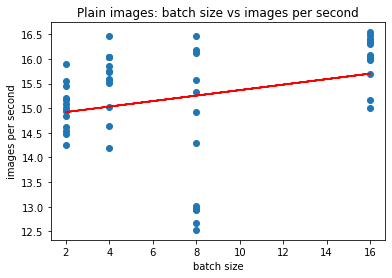

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.677
Model:                            OLS   Adj. R-squared (uncentered):              0.671
Method:                 Least Squares   F-statistic:                              107.0
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    4.04e-14
Time:                        22:04:15   Log-Likelihood:                         -186.13
No. Observations:                  52   AIC:                                      374.3
Df Residuals:                      51   BIC:                                      376.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

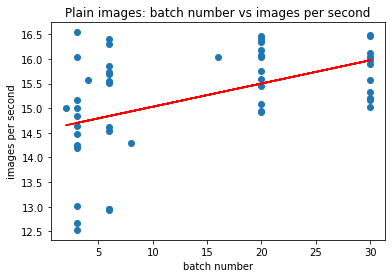

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.658
Method:                 Least Squares   F-statistic:                              101.1
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    1.07e-13
Time:                        22:04:15   Log-Likelihood:                         -187.11
No. Observations:                  52   AIC:                                      376.2
Df Residuals:                      51   BIC:                                      378.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

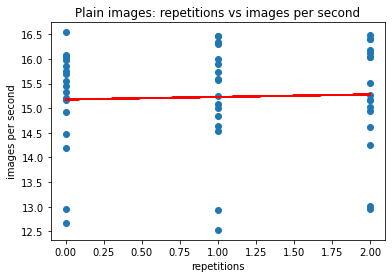

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.600
Model:                            OLS   Adj. R-squared (uncentered):              0.592
Method:                 Least Squares   F-statistic:                              74.92
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    1.64e-11
Time:                        22:04:16   Log-Likelihood:                         -188.02
No. Observations:                  51   AIC:                                      378.0
Df Residuals:                      50   BIC:                                      380.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

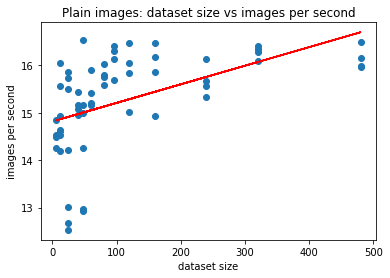

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.471
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              53.40
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    7.47e-10
Time:                        22:04:16   Log-Likelihood:                         -233.54
No. Observations:                  61   AIC:                                      469.1
Df Residuals:                      60   BIC:                                      471.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [0]:
#batch size
batchsizePlainImgs = pd.read_pickle(BUCKET+'/batchSizeRawPoints_200604-2028PlainImgs.pkl') 
batchsizePlainImgs2 = pd.read_pickle(BUCKET+'/batchSizeAverage_200604-2029PlainImgs.pkl')
batchsizePlainImgs+=batchsizePlainImgs2
batchsizePlainImgs_X =np.array([i[0] for i in batchsizePlainImgs]).reshape(-1, 1)
batchsizePlainImgsImagesPerSecond_Y=np.array([i[1] for i in batchsizePlainImgs]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(batchsizePlainImgs_X, batchsizePlainImgsImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(batchsizePlainImgs_X)  # make predictions
plt.scatter(batchsizePlainImgs_X, batchsizePlainImgsImagesPerSecond_Y)
plt.plot(batchsizePlainImgs_X, Y_pred, color='red')
plt.title("Plain images: batch size vs images per second")
plt.xlabel("batch size")
plt.ylabel("images per second")
plt.show()

# We use statsmodels to print values like coef, pvalue... (not supported in sklearn yet)
modelbatchsizePlainImgs = sm.OLS(batchsizePlainImgsImagesPerSecond_Y, batchsizePlainImgs_X).fit()
predictionsbatchsizePlainImgs = modelbatchsizePlainImgs.predict(batchsizePlainImgs_X) 
print_modelbatchsizePlainImgs = modelbatchsizePlainImgs.summary()
print(print_modelbatchsizePlainImgs)

# batch number
batchnumberPlainImgs = pd.read_pickle(BUCKET+'/batchNumberRawPoints_200604-2028PlainImgs.pkl') 
batchnumberPlainImgs2 = pd.read_pickle(BUCKET+'/batchNumberAverage_200604-2029PlainImgs.pkl')
batchnumberPlainImgs+=batchsizePlainImgs2
batchnumberPlainImgs_X =np.array([i[0] for i in batchnumberPlainImgs]).reshape(-1, 1)
batchnumberPlainImgsImagesPerSecond_Y=np.array([i[1] for i in batchnumberPlainImgs]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(batchnumberPlainImgs_X, batchnumberPlainImgsImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(batchnumberPlainImgs_X)  # make predictions
plt.scatter(batchnumberPlainImgs_X, batchnumberPlainImgsImagesPerSecond_Y)
plt.plot(batchnumberPlainImgs_X, Y_pred, color='red')
plt.title("Plain images: batch number vs images per second")
plt.xlabel("batch number")
plt.ylabel("images per second")
plt.show()

modelbatchnumberPlainImgs = sm.OLS(batchnumberPlainImgsImagesPerSecond_Y, batchnumberPlainImgs_X).fit()
predictionsbatchnumberPlainImgs = modelbatchnumberPlainImgs.predict(batchnumberPlainImgs_X) 
print_modelbatchnumberPlainImgs = modelbatchnumberPlainImgs.summary()
print(print_modelbatchnumberPlainImgs)

# repetitions
repetitionsPlainImgs = pd.read_pickle(BUCKET+'/repetitionsRawPoints_200604-2029PlainImgs.pkl') 
repetitionsPlainImgs2 = pd.read_pickle(BUCKET+'/repetitionsAverage_200604-2029PlainImgs.pkl')
repetitionsPlainImgs+=repetitionsPlainImgs2
repetitionsPlainImgs_X =np.array([i[0] for i in repetitionsPlainImgs]).reshape(-1, 1)
repetitionsPlainImgsImagesPerSecond_Y=np.array([i[1] for i in repetitionsPlainImgs]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(repetitionsPlainImgs_X, repetitionsPlainImgsImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(repetitionsPlainImgs_X)  # make predictions
plt.scatter(repetitionsPlainImgs_X, repetitionsPlainImgsImagesPerSecond_Y)
plt.plot(repetitionsPlainImgs_X, Y_pred, color='red')
plt.title("Plain images: repetitions vs images per second")
plt.xlabel("repetitions")
plt.ylabel("images per second")
plt.show()

modelrepetitionsPlainImgs = sm.OLS(repetitionsPlainImgsImagesPerSecond_Y, repetitionsPlainImgs_X).fit()
predictionsrepetitionsPlainImgs = modelrepetitionsPlainImgs.predict(repetitionsPlainImgs_X) 
print_modelrepetitionsPlainImgs = modelrepetitionsPlainImgs.summary()
print(print_modelrepetitionsPlainImgs)

# dataset size
datasetsizePlainImgs = pd.read_pickle(BUCKET+'/datasetSizeRawPoints_200604-2029PlainImgs.pkl') 
datasetsizePlainImgs2 = pd.read_pickle(BUCKET+'/datasetSizeAverage_200604-2029PlainImgs.pkl')
datasetsizePlainImgs+=datasetsizePlainImgs2
datasetsizePlainImgs_X =np.array([i[0] for i in datasetsizePlainImgs]).reshape(-1, 1)
datasetsizePlainImgsImagesPerSecond_Y=np.array([i[1] for i in datasetsizePlainImgs]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(datasetsizePlainImgs_X, datasetsizePlainImgsImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(datasetsizePlainImgs_X)  # make predictions
plt.scatter(datasetsizePlainImgs_X, datasetsizePlainImgsImagesPerSecond_Y)
plt.plot(datasetsizePlainImgs_X, Y_pred, color='red')
plt.title("Plain images: dataset size vs images per second")
plt.xlabel("dataset size")
plt.ylabel("images per second")
plt.show()

modeldatasetsizePlainImgs = sm.OLS(datasetsizePlainImgsImagesPerSecond_Y, datasetsizePlainImgs_X).fit()
predictionsdatasetsizePlainImgs = modeldatasetsizePlainImgs.predict(datasetsizePlainImgs_X) 
print_modeldatasetsizePlainImgs = modeldatasetsizePlainImgs.summary()
print(print_modeldatasetsizePlainImgs)

**TFRecordFiles**

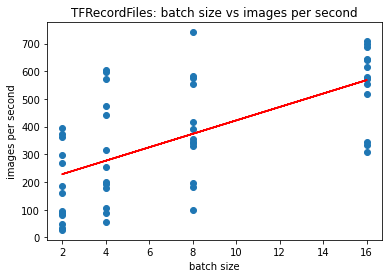

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.780
Method:                 Least Squares   F-statistic:                              185.1
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    1.34e-18
Time:                        22:38:32   Log-Likelihood:                         -347.77
No. Observations:                  52   AIC:                                      697.5
Df Residuals:                      51   BIC:                                      699.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

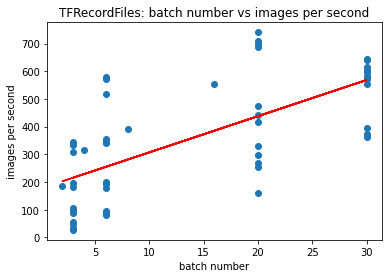

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.798
Model:                            OLS   Adj. R-squared (uncentered):              0.794
Method:                 Least Squares   F-statistic:                              201.2
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    2.45e-19
Time:                        22:38:33   Log-Likelihood:                         -346.05
No. Observations:                  52   AIC:                                      694.1
Df Residuals:                      51   BIC:                                      696.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

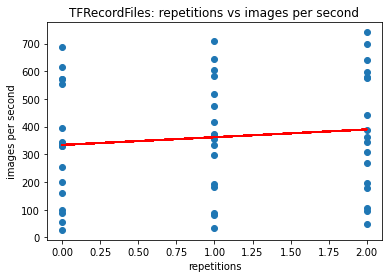

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.499
Model:                            OLS   Adj. R-squared (uncentered):              0.489
Method:                 Least Squares   F-statistic:                              49.74
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    4.97e-09
Time:                        22:38:33   Log-Likelihood:                         -362.47
No. Observations:                  51   AIC:                                      726.9
Df Residuals:                      50   BIC:                                      728.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

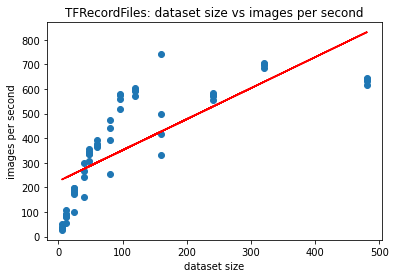

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.742
Model:                            OLS   Adj. R-squared (uncentered):              0.737
Method:                 Least Squares   F-statistic:                              172.1
Date:                Thu, 04 Jun 2020   Prob (F-statistic):                    2.80e-19
Time:                        22:38:34   Log-Likelihood:                         -414.73
No. Observations:                  61   AIC:                                      831.5
Df Residuals:                      60   BIC:                                      833.6
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [0]:
#batch size
batchsizeTFRecordFiles = pd.read_pickle(BUCKET+'/batchSizeRawPoints_200604-2031TFRecordFiles.pkl') 
batchsizeTFRecordFiles2 = pd.read_pickle(BUCKET+'/batchSizeAverage_200604-2031TFRecordFiles.pkl')
batchsizeTFRecordFiles+=batchsizeTFRecordFiles2
batchsizeTFRecordFiles_X =np.array([i[0] for i in batchsizeTFRecordFiles]).reshape(-1, 1)
batchsizeTFRecordFilesImagesPerSecond_Y=np.array([i[1] for i in batchsizeTFRecordFiles]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(batchsizeTFRecordFiles_X, batchsizeTFRecordFilesImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(batchsizeTFRecordFiles_X)  # make predictions
plt.scatter(batchsizeTFRecordFiles_X, batchsizeTFRecordFilesImagesPerSecond_Y)
plt.plot(batchsizeTFRecordFiles_X, Y_pred, color='red')
plt.title("TFRecordFiles: batch size vs images per second")
plt.xlabel("batch size")
plt.ylabel("images per second")
plt.show()

# We use statsmodels to print values like coef, pvalue... (not supported in sklearn yet)
modelbatchsizeTFRecordFiles = sm.OLS(batchsizeTFRecordFilesImagesPerSecond_Y, batchsizeTFRecordFiles_X).fit()
predictionsbatchsizeTFRecordFiles = modelbatchsizeTFRecordFiles.predict(batchsizeTFRecordFiles_X) 
print_modelbatchsizeTFRecordFiles = modelbatchsizeTFRecordFiles.summary()
print(print_modelbatchsizeTFRecordFiles)

# batch number
batchnumberTFRecordFiles = pd.read_pickle(BUCKET+'/batchNumberRawPoints_200604-2031TFRecordFiles.pkl') 
batchnumberTFRecordFiles2 = pd.read_pickle(BUCKET+'/batchNumberAverage_200604-2031TFRecordFiles.pkl')
batchnumberTFRecordFiles+=batchsizeTFRecordFiles2
batchnumberTFRecordFiles_X =np.array([i[0] for i in batchnumberTFRecordFiles]).reshape(-1, 1)
batchnumberTFRecordFilesImagesPerSecond_Y=np.array([i[1] for i in batchnumberTFRecordFiles]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(batchnumberTFRecordFiles_X, batchnumberTFRecordFilesImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(batchnumberTFRecordFiles_X)  # make predictions
plt.scatter(batchnumberTFRecordFiles_X, batchnumberTFRecordFilesImagesPerSecond_Y)
plt.plot(batchnumberTFRecordFiles_X, Y_pred, color='red')
plt.title("TFRecordFiles: batch number vs images per second")
plt.xlabel("batch number")
plt.ylabel("images per second")
plt.show()

modelbatchnumberTFRecordFiles = sm.OLS(batchnumberTFRecordFilesImagesPerSecond_Y, batchnumberTFRecordFiles_X).fit()
predictionsbatchnumberTFRecordFiles = modelbatchnumberTFRecordFiles.predict(batchnumberTFRecordFiles_X) 
print_modelbatchnumberTFRecordFiles = modelbatchnumberTFRecordFiles.summary()
print(print_modelbatchnumberTFRecordFiles)

# repetitions
repetitionsTFRecordFiles = pd.read_pickle(BUCKET+'/repetitionsRawPoints_200604-2031TFRecordFiles.pkl') 
repetitionsTFRecordFiles2 = pd.read_pickle(BUCKET+'/repetitionsAverage_200604-2031TFRecordFiles.pkl')
repetitionsTFRecordFiles+=repetitionsTFRecordFiles2
repetitionsTFRecordFiles_X =np.array([i[0] for i in repetitionsTFRecordFiles]).reshape(-1, 1)
repetitionsTFRecordFilesImagesPerSecond_Y=np.array([i[1] for i in repetitionsTFRecordFiles]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(repetitionsTFRecordFiles_X, repetitionsTFRecordFilesImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(repetitionsTFRecordFiles_X)  # make predictions
plt.scatter(repetitionsTFRecordFiles_X, repetitionsTFRecordFilesImagesPerSecond_Y)
plt.plot(repetitionsTFRecordFiles_X, Y_pred, color='red')
plt.title("TFRecordFiles: repetitions vs images per second")
plt.xlabel("repetitions")
plt.ylabel("images per second")
plt.show()

modelrepetitionsTFRecordFiles = sm.OLS(repetitionsTFRecordFilesImagesPerSecond_Y, repetitionsTFRecordFiles_X).fit()
predictionsrepetitionsTFRecordFiles = modelrepetitionsTFRecordFiles.predict(repetitionsTFRecordFiles_X) 
print_modelrepetitionsTFRecordFiles = modelrepetitionsTFRecordFiles.summary()
print(print_modelrepetitionsTFRecordFiles)

# dataset size
datasetsizeTFRecordFiles = pd.read_pickle(BUCKET+'/datasetSizeRawPoints_200604-2031TFRecordFiles.pkl') 
datasetsizeTFRecordFiles2 = pd.read_pickle(BUCKET+'/datasetSizeAverage_200604-2031TFRecordFiles.pkl')
datasetsizeTFRecordFiles+=datasetsizeTFRecordFiles2
datasetsizeTFRecordFiles_X =np.array([i[0] for i in datasetsizeTFRecordFiles]).reshape(-1, 1)
datasetsizeTFRecordFilesImagesPerSecond_Y=np.array([i[1] for i in datasetsizeTFRecordFiles]).reshape(-1, 1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(datasetsizeTFRecordFiles_X, datasetsizeTFRecordFilesImagesPerSecond_Y)  # perform linear regression
Y_pred = linear_regressor.predict(datasetsizeTFRecordFiles_X)  # make predictions
plt.scatter(datasetsizeTFRecordFiles_X, datasetsizeTFRecordFilesImagesPerSecond_Y)
plt.plot(datasetsizeTFRecordFiles_X, Y_pred, color='red')
plt.title("TFRecordFiles: dataset size vs images per second")
plt.xlabel("dataset size")
plt.ylabel("images per second")
plt.show()

modeldatasetsizeTFRecordFiles = sm.OLS(datasetsizeTFRecordFilesImagesPerSecond_Y, datasetsizeTFRecordFiles_X).fit()
predictionsdatasetsizeTFRecordFiles = modeldatasetsizeTFRecordFiles.predict(datasetsizeTFRecordFiles_X) 
print_modeldatasetsizeTFRecordFiles = modeldatasetsizeTFRecordFiles.summary()
print(print_modeldatasetsizeTFRecordFiles)

## Task 3: Write TFRecord files to the cloud with Spark (20%)

This task of pre-processing images and creating TFRecord files is a more straightforward case of parallelisation. We will again use Spark.

### 3a)	Create the script (10%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over the partitions**. 

You need to **copy** over and **adapt** the resizing and recompression function to Spark (only one argument). (2%)
**Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (2%)
Then **use the functions** like with the TensorFlow Dataset object. (2%)

The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. The return value of that function is not essential. You can return the filename, so that you have a list of the created TFRecord files. (4%) 


In [79]:
%%writefile readDatasetInSpark.py

import pyspark
import itertools
import numpy as np 
import tensorflow as tf
import os, sys, math

PROJECT = 'bigdataprojectpabloquinoa'
BUCKET = 'gs://{}-storage'.format(PROJECT) 
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names
TARGET_SIZE = [192, 192]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']
PARTITIONS=5 

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(x):
    image=x[0]
    label=x[1]
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(x):
    image=x[0]
    label=x[1]
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label, height, width

# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def writeTFRecord(splitIndex, iterator):
    writtenFiles = []
    filename = GCS_OUTPUT + "{}.tfrec".format(splitIndex) # we create 1 .tfrec file per partition
    with tf.io.TFRecordWriter(filename) as out_file:
      for element in iterator: #iterate over all partitions of this RDD
        image=element[0]
        label=element[1]
        height=element[2]
        width=element[3]
        example = to_tfrecord(out_file,
                  image.numpy(), # re-compressed image: already a byte string
                  label.numpy() #, height.numpy()[i], width.numpy()[i]
                  )
        out_file.write(example.SerializeToString())
    writtenFiles.append(filename)  
    yield writtenFiles

# RDD that contains the list of image filenames
filenames = tf.io.gfile.glob(GCS_PATTERN)
sc = pyspark.SparkContext.getOrCreate()
rdd_filenames = sc.parallelize(filenames,numSlices=PARTITIONS)
dataset1RDD = rdd_filenames.map(decode_jpeg_and_label)
dataset2RDD = dataset1RDD.map(resize_and_crop_image)  
dataset3RDD = dataset2RDD.map(recompress_image)
filenamesWritten = dataset3RDD.mapPartitionsWithIndex(writeTFRecord).collect()

Overwriting readDatasetInSpark.py


### 3b)	Run and test (2%)

Run the script and test the output. 


In [9]:
# Created the cluster with 4 machines. 1 master and 3 workers 
# Master with 200gb SSD and 3 workers with standard disk 570GB (2CPU each worker and master)
REGION = 'us-central1'
CLUSTER = 'cluster4machines'

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 200 \
    --num-workers 3 \
    --worker-machine-type n1-standard-2 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size 570 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.1.0


Waiting on operation [projects/bigdataprojectpabloquinoa/regions/us-central1/operations/c66eba68-d3cc-3d11-8312-b447c4dd53c7].

Created [https://dataproc.googleapis.com/v1/projects/bigdataprojectpabloquinoa/regions/us-central1/clusters/cluster4machines] Cluster placed in zone [us-central1-c].


In [80]:
# submit the job to the cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION readDatasetInSpark.py

Job [fded1829b93547ae8900b7bcb09175dd] submitted.
Waiting for job output...
2020-06-06 15:49:31.860750: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-06 15:49:31.860911: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-06 15:49:31.860928: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
20/06/06 15:49:34 INFO org.spark_project.jetty.util.log: Logging initialized @5519ms
20/06/06 15:49:34 INFO org.s

In [81]:
!gsutil ls gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/

gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers0.tfrec
gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers1.tfrec
gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers2.tfrec
gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers3.tfrec
gs://bigdataprojectpabloquinoa-storage/tfrecords-jpeg-192x192-2/flowers4.tfrec


Read from the TFRecord Dataset to test. 


In [0]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' 
TARGET_SIZE = [192, 192]

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecodedSpark = load_dataset(filenames)

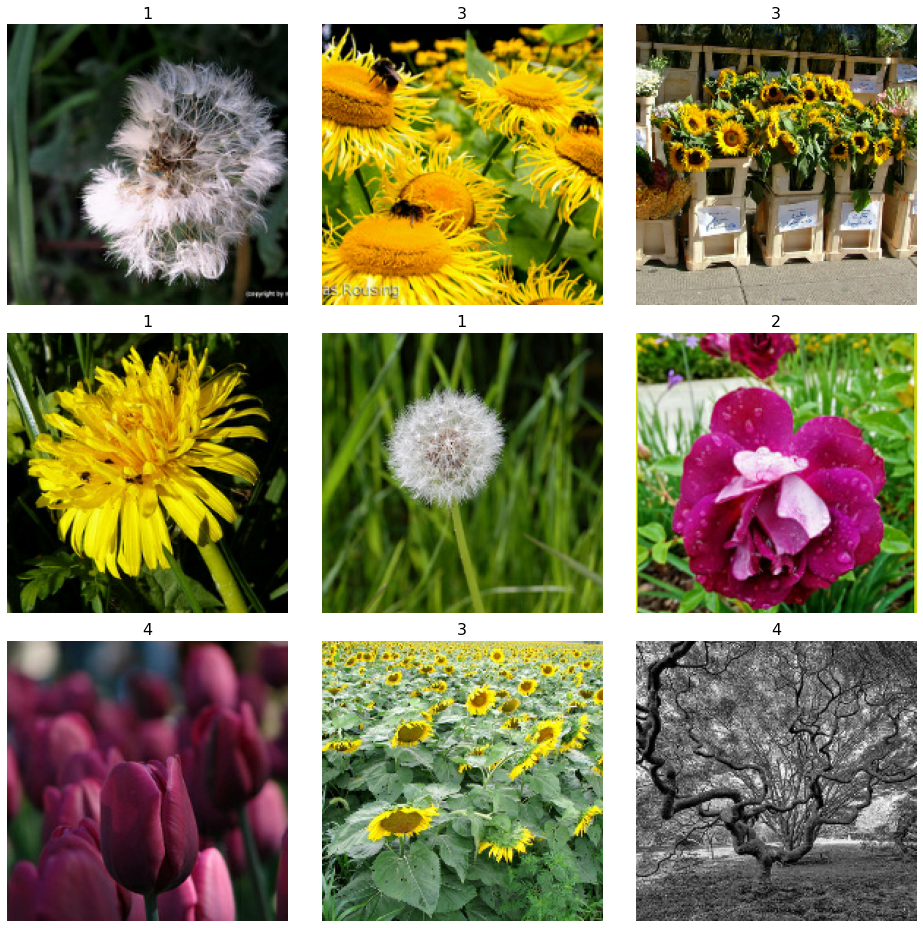

In [83]:
display_9_images_from_dataset(datasetDecodedSpark)

In [84]:
batched_dataset = datasetDecodedSpark.batch(2)
sample_set = batched_dataset.take(3)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (2, 192, 192, 3), ['1', '3'])
Image batch shape (2, 192, 192, 3), ['3', '1'])
Image batch shape (2, 192, 192, 3), ['1', '2'])


### 3c)	Experiment and discussion (8%)

i)	Test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with quadruple resources. Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

ii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs. (2%)

Write your answers in the report.

In [87]:
# In section 3b we already tested with 4 machines. Now we do the same but using just a machine (1 master) with 4 CPUs
# Created the cluster with 1 machine with 300GB of SSD and 4 CPUs
REGION = 'us-central1'
CLUSTER = 'cluster1machine'

!gcloud dataproc clusters create $CLUSTER \
    --bucket $PROJECT-storage \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-4 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 300 \
    --num-workers 0 \
    --max-idle 3600s \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES=tensorflow==2.1.0



Waiting on operation [projects/bigdataprojectpabloquinoa/regions/us-central1/operations/3f09a5a2-c0e1-3f28-b8de-d56b802bb5d4].
Created [https://dataproc.googleapis.com/v1/projects/bigdataprojectpabloquinoa/regions/us-central1/clusters/cluster1machine] Cluster placed in zone [us-central1-a].


In [88]:
# submit the job to this new cluster
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION readDatasetInSpark.py

Job [97ebd5452b7d486dbad96451dd0febc8] submitted.
Waiting for job output...
2020-06-06 16:01:24.201191: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-06 16:01:24.201321: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2020-06-06 16:01:24.201331: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
20/06/06 16:01:26 INFO org.spark_project.jetty.util.log: Logging initialized @6121ms
20/06/06 16:01:27 INFO org.s

# Section 2: Machine Learning in the Cloud

In this section we will use the pre-processed data with the GC AI-Platform for Machine Learning. 

## Preparation: Machine Learning Setup

As in Section 1, in this section, we get started based on code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.


### Create Train and Test Sets 

We will first **set up a few variables** for the machine learning. 

In [0]:
BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

Then we split the data into train and test sets.

In [116]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))

len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 13 training files and 3 validation files
With a batch size of 64, there will be 46 batches per training epoch and 10 batch(es) per validation run.


Then we split the train and validation sets into batches. 

In [0]:
def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [122]:
# just a little test to check the datasets
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (64, 192, 192, 3), ['0', '0', '4', '1', '0', '2', '0', '1', '3', '4', '2', '1', '3', '1', '0', '2', '4', '3', '4', '1', '4', '0', '0', '4', '4', '1', '4', '4', '0', '3', '2', '3', '3', '3', '3', '1', '0', '1', '3', '4', '3', '1', '1', '4', '2', '4', '1', '3', '2', '3', '3', '0', '3', '3', '3', '2', '0', '4', '4', '1', '4', '1', '3', '1'])
Image batch shape (64, 192, 192, 3), ['4', '4', '2', '0', '2', '2', '4', '1', '3', '3', '3', '1', '4', '2', '3', '4', '1', '3', '2', '1', '0', '2', '3', '0', '2', '4', '1', '2', '4', '3', '2', '3', '3', '4', '3', '3', '1', '2', '1', '4', '4', '4', '0', '2', '3', '4', '2', '1', '1', '4', '0', '3', '0', '4', '4', '4', '1', '1', '4', '4', '1', '3', '3', '0'])
Image batch shape (64, 192, 192, 3), ['3', '0', '1', '3', '1', '4', '2', '0', '0', '0', '2', '4', '4', '4', '2', '3', '2', '3', '0', '4', '2', '4', '1', '2', '1', '0', '4', '0', '1', '1', '4', '0', '4', '2', '3', '4', '3', '3', '1', '4', '2', '3', '1', '1', '4', '2', '2', '1', '1',

### Set up a pretrained model

Here we load a **pre-trained model** and add a **fully connected** layer plus the **output layer**.
**Only** our **added layers** are **trained**, which lets us benefit from the trained model without the computation or data needed to re-train from scratch.

We use **MobileNetV2** here, which is a **relatively small and efficient** model. You can also try the larger ones, if you like. 

In [123]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 46080)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               4608100   
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 6,866,589
Trainable params: 4,608,605
Non-trainable params: 2,257,984
_________________________________________________________________


### Local Training

With **model and data**, we can now start the **training**. You can keep training time short by making sure that you use a runtime with GPU. You should also the number of epochs low, for initial tests. 
The **history** object keeps a record of the training progress.

In [124]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Epoch 1/5
46/46 [==============================] - 7s 159ms/step - loss: 3.0098 - accuracy: 0.2418 - val_loss: 1.6065 - val_accuracy: 0.2406
Epoch 2/5
46/46 [==============================] - 6s 132ms/step - loss: 1.6066 - accuracy: 0.2466 - val_loss: 1.5993 - val_accuracy: 0.2406
Epoch 3/5
46/46 [==============================] - 6s 132ms/step - loss: 1.6035 - accuracy: 0.2480 - val_loss: 1.6051 - val_accuracy: 0.2406
Epoch 4/5
46/46 [==============================] - 6s 133ms/step - loss: 1.5991 - accuracy: 0.2473 - val_loss: 1.5974 - val_accuracy: 0.2406
Epoch 5/5
46/46 [==============================] - 6s 133ms/step - loss: 1.5887 - accuracy: 0.2463 - val_loss: 1.6033 - val_accuracy: 0.2406
Wall clock time = 37.06948781013489


As a result we have the printed training time, the trained model, and the history object, which we can visualise (not essential for us here).

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


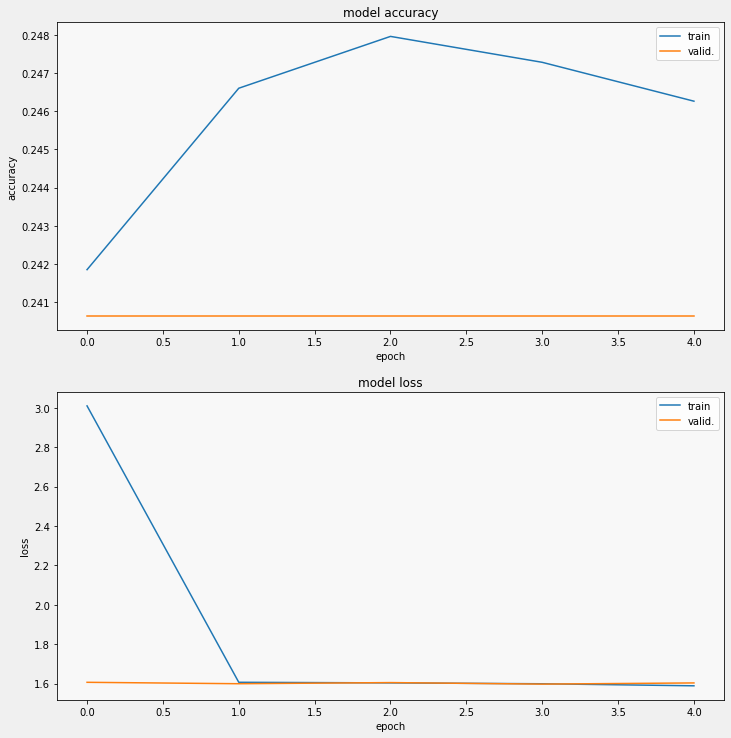

In [125]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

We can check a few examples with the predicted classes.

In [16]:
def dataset_to_numpy_util(dataset, N):
  dataset = dataset.batch(N)
  
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;

  return numpy_images, numpy_labels

# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

[b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion']


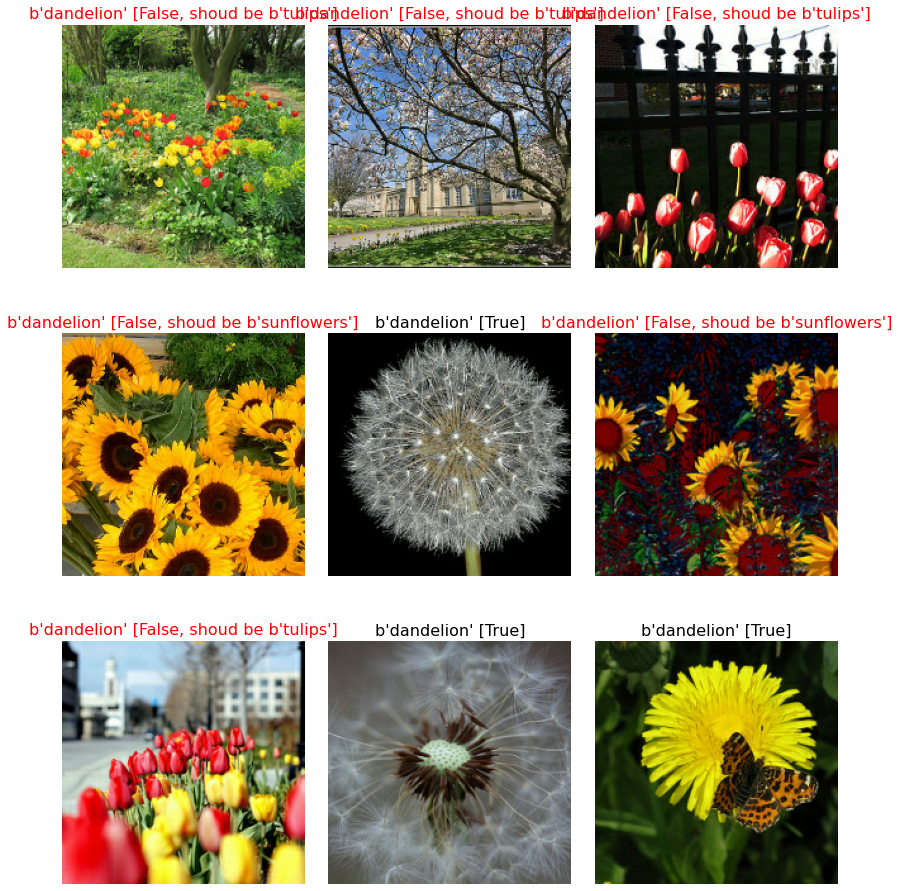

In [19]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 4: Machine learning in the cloud (20%)

Your task is now to **execute** the **training** in the **cloud** on the **AI-Platform**.

If you haven't already used the AI-Platform, or enabled it using the GUI, you can enable its usage by executing the cell below.

In [0]:
!gcloud services enable ml.googleapis.com

### 4a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a '**package**'. 
The package can contain complex software systems and extensive  information on the setup. 
We will **keep** the package as **simple** as possible here.



i) The **minimal** 'package' in for AI-Platform needs a directory with **two modules** (i.e. Python files). 
Create a directory 'trainer' and then an empty file **`trainer/__init__.py`**. 
This can be done by using the **command line tools `mkdir` and `touch`**. 
**List the directory contents** to show that the file **exists**. (1%) 

In [5]:
!mkdir trainer
!pwd

mkdir: cannot create directory ‘trainer’: File exists
/content/drive/My Drive/BD-CW2


In [0]:
!touch trainer/__init__.py

In [162]:
%cd trainer

/content/drive/My Drive/BD-CW2/trainer


In [163]:
!ls -l #list the files inside trainer to show that __init__.py was created 

total 6
-rw------- 1 root root    0 Jun  7 11:13 __init__.py
-rw------- 1 root root 5594 Jun  7 15:59 task.py


In [164]:
%cd ../

/content/drive/My Drive/BD-CW2


ii) The other file we need is the **module** with the **training code**, which we will call **`task.py`**. 

We can build this file by **combining** the **previous cells** under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to **save the model itself** and the **training history** into a file after training. 
You can not pickle the `history` object returned by `model.fit`, but its **data in `history.history`** can be **pickled**. 
For **saving the model**, use `model.save()`.
In addition, **save** the measured **training time** and information about the **configuration** (should be passed as a parameter). 
Write the necessary code, like in section 2 when preparing jobs for Spark/Dataproc.

If you use **argparse** as in section 2 (recommended), then you need to **define an argument** `--job-dir` that will be passed through from the AI-Platform to your program when you define it.
(6%)

In [99]:
%%writefile task.py

import sys
import argparse
import pickle 
import tensorflow as tf
import time

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API
TARGET_SIZE = [192, 192] # the resolution for the images
PROJECT = 'bigdataprojectpabloquinoa'
BUCKET = 'gs://{}-storage'.format(PROJECT) 
BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

# set up a pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# start training here
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0

#read configuration
parser = argparse.ArgumentParser() # get a parser object
parser.add_argument('--job-dir', required=True,
                        help='GCS location to write checkpoints and export models') # add a required argument
parser.add_argument('--num_workers', metavar='num_workers', required=True,
                        help='number of workers for the cluster') # add a required argument
parser.add_argument('--machine_type', metavar='machine_type', required=True,
                        help='machine type of the cluster') # add a required argument
args = parser.parse_args() # read the value
clusterConfiguration=(args.num_workers,args.machine_type)

# We save the model, training history, training time and cluster configuration in the bucket
model.save(BUCKET+"/model")
def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
save(history.history,BUCKET,"history.pkl")
save(tt,BUCKET,"trainingTime.pkl")
clusterConfiguration=(args.num_workers,args.machine_type)
save(clusterConfiguration,BUCKET,"clusterConfiguration.pkl")


Overwriting task.py


### 4b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can **submit the package as a job**. AI-Platform operation is **serverless**, therefore we do not need to create a cluster ourselves, but we just submit a job and the master and workers will be provided automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information **how to submit a training job** in GCS AI-Platform.  

The **job** will wait in a **queue** for **some minutes** before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to **test** the script **locally before** you submit to the **cloud**. 

You can get **powerful hardware** on AI-Platform. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.

However, the machines with P100 and V100 GPUs are quite **expensive**. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.


In [165]:
# AI Platform parameters
TRAINER_PACKAGE_PATH = "trainer"
MAIN_TRAINER_MODULE = "trainer.task"
PACKAGE_STAGING_PATH = BUCKET
JOB_NAME = "flowers_training19" # you need a new job name for every run
JOB_DIR = BUCKET + '/jobs/' + JOB_NAME
MACHINE_TYPE="standard_gpu"
NUM_WORKERS=3

!gcloud ai-platform jobs submit training $JOB_NAME \
    --package-path $TRAINER_PACKAGE_PATH \
    --module-name $MAIN_TRAINER_MODULE \
    --staging-bucket $PACKAGE_STAGING_PATH \
    --job-dir $JOB_DIR \
    --region $REGION \
    --scale-tier CUSTOM \
    --worker-count $NUM_WORKERS \
    --worker-machine-type $MACHINE_TYPE \
    --master-machine-type $MACHINE_TYPE \
    --runtime-version 2.1 \
    --python-version 3.7 \
    -- \
    --num_workers $NUM_WORKERS \
    --machine_type $MACHINE_TYPE \

Job [flowers_training19] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training19

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training19
jobId: flowers_training19
state: QUEUED


Normally, gcloud returns immediately after job submission. If you want to keep track here, you can use the cell below. Usually, it is more practical to use the web interface https://console.cloud.google.com/ai-platform/jobs .

In [0]:
!gcloud ai-platform jobs stream-logs $JOB_NAME

After training, **retrieve the history object and plot** the accuracy and loss curves based on the saved history to **check that the training worked**.

In [166]:
!gsutil ls $BUCKET

gs://bigdataprojectpabloquinoa-storage/clusterConfiguration-mirroredStrategy-128batchsize.pkl
gs://bigdataprojectpabloquinoa-storage/clusterConfiguration-mirroredStrategy-64batchsize.pkl
gs://bigdataprojectpabloquinoa-storage/clusterConfiguration.pkl
gs://bigdataprojectpabloquinoa-storage/history-mirroredStrategy-128batchsize.pkl
gs://bigdataprojectpabloquinoa-storage/history-mirroredStrategy-64batchsize.pkl
gs://bigdataprojectpabloquinoa-storage/history.pkl
gs://bigdataprojectpabloquinoa-storage/trainingTime-mirroredStrategy-128batchsize.pkl
gs://bigdataprojectpabloquinoa-storage/trainingTime-mirroredStrategy-64batchsize.pkl
gs://bigdataprojectpabloquinoa-storage/trainingTime.pkl
gs://bigdataprojectpabloquinoa-storage/flowers_training10/
gs://bigdataprojectpabloquinoa-storage/flowers_training11/
gs://bigdataprojectpabloquinoa-storage/flowers_training12/
gs://bigdataprojectpabloquinoa-storage/flowers_training13/
gs://bigdataprojectpabloquinoa-storage/flowers_training14/
gs://bigdatapro

('3', 'standard_gpu')
37.5880389213562


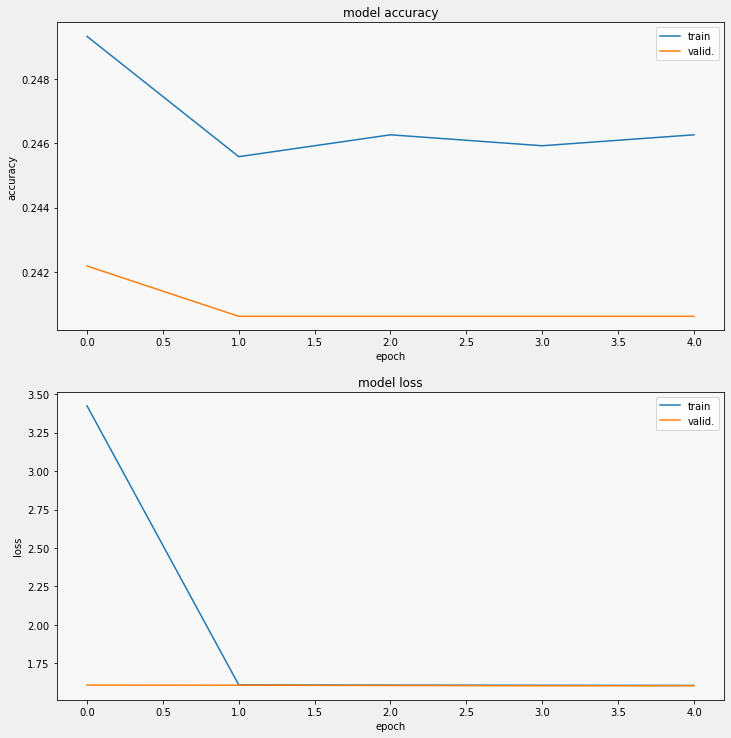

In [127]:
hist=pd.read_pickle(BUCKET+"/history.pkl")
display_training_curves(hist['accuracy'], hist['val_accuracy'], 'accuracy', 211)
display_training_curves(hist['loss'], hist['val_loss'], 'loss', 212)
clusterConfig=pd.read_pickle(BUCKET+"/clusterConfiguration.pkl")
print(clusterConfig)
trainTime=pd.read_pickle(BUCKET+"/trainingTime.pkl")
print(trainTime)

### 4c) Distributed learning	(10%)

Apply a **distributed learning strategy** to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example).  
Add the necessary changes to the code.

**Experiment** with **different strategies and batch sizes**. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 


In [160]:
%%writefile task.py

import sys
import argparse
import pickle 
import tensorflow as tf
import time

# Apply a distributed learning strategy
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF


AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API
TARGET_SIZE = [192, 192] # the resolution for the images
PROJECT = 'bigdataprojectpabloquinoa'
BUCKET = 'gs://{}-storage'.format(PROJECT) 
#BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
VALIDATION_SPLIT = 0.19 # proportion of data used for validation
SAMPLE_NUM = 3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def get_batched_dataset(filenames, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
        # Best practices for Keras:
        # Training dataset: repeat then batch
        # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

#AutoShardPolicy OFF
training_dataset_no_auto_shard = training_dataset.with_options(options)
validation_dataset_no_auto_shard = validation_dataset.with_options(options)


#enclosing the model building and model.compile() call inside strategy.scope()
with strategy.scope():
  # set up a pretrained model
  pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
  pretrained_model.trainable = False

  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

# start training here
tt0 = time.time()
history = model.fit(training_dataset_no_auto_shard, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset_no_auto_shard, validation_steps=validation_steps)
tt = time.time() - tt0

#read configuration
parser = argparse.ArgumentParser() # get a parser object
parser.add_argument('--job-dir', required=True,
                        help='GCS location to write checkpoints and export models') # add a required argument
parser.add_argument('--num_workers', metavar='num_workers', required=True,
                        help='number of workers for the cluster') # add a required argument
parser.add_argument('--machine_type', metavar='machine_type', required=True,
                        help='machine type of the cluster') # add a required argument
args = parser.parse_args() # read the value
clusterConfiguration=(args.num_workers,args.machine_type)

# We save the model, training history, training time and cluster configuration in the bucket
model.save(BUCKET+"/model")
def save(object, bucket, filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
save(history.history,BUCKET,"history-mirroredStrategy-128batchsize.pkl")
save(tt,BUCKET,"trainingTime-mirroredStrategy-128batchsize.pkl")
clusterConfiguration=(args.num_workers,args.machine_type)
save(clusterConfiguration,BUCKET,"clusterConfiguration-mirroredStrategy-128batchsize.pkl")


Overwriting task.py


After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a **table** in your report together with a textual answer.

**Batch size: 64 with a distributed mirrored strategy**

('3', 'standard_gpu')
34.81302356719971


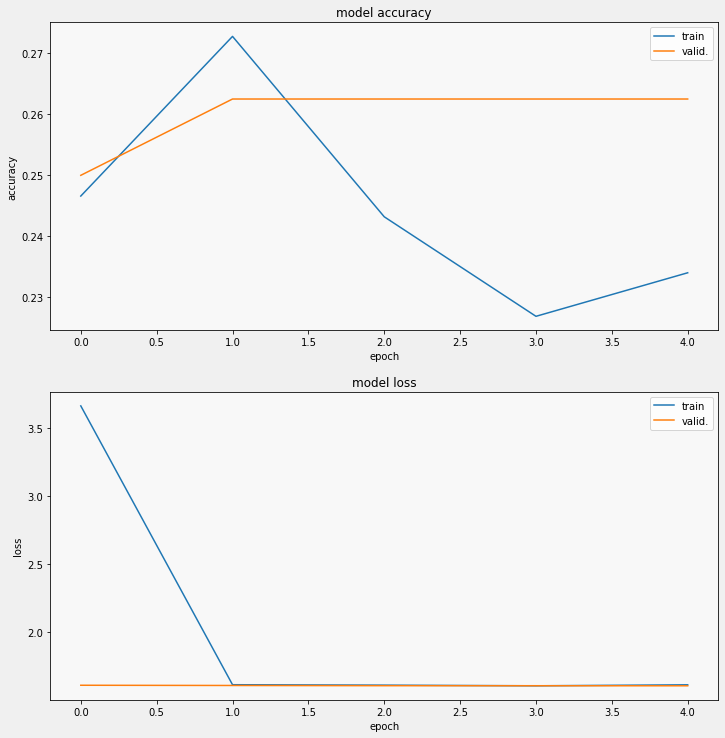

In [158]:
hist=pd.read_pickle(BUCKET+"/history-mirroredStrategy-64batchsize.pkl")
display_training_curves(hist['accuracy'], hist['val_accuracy'], 'accuracy', 211)
display_training_curves(hist['loss'], hist['val_loss'], 'loss', 212)
clusterConfig=pd.read_pickle(BUCKET+"/clusterConfiguration-mirroredStrategy-64batchsize.pkl")
print(clusterConfig)
trainTime=pd.read_pickle(BUCKET+"/trainingTime-mirroredStrategy-64batchsize.pkl")
print(trainTime)

**Batch size: 128 with a distributed mirrored strategy**

('3', 'standard_gpu')
26.083804607391357


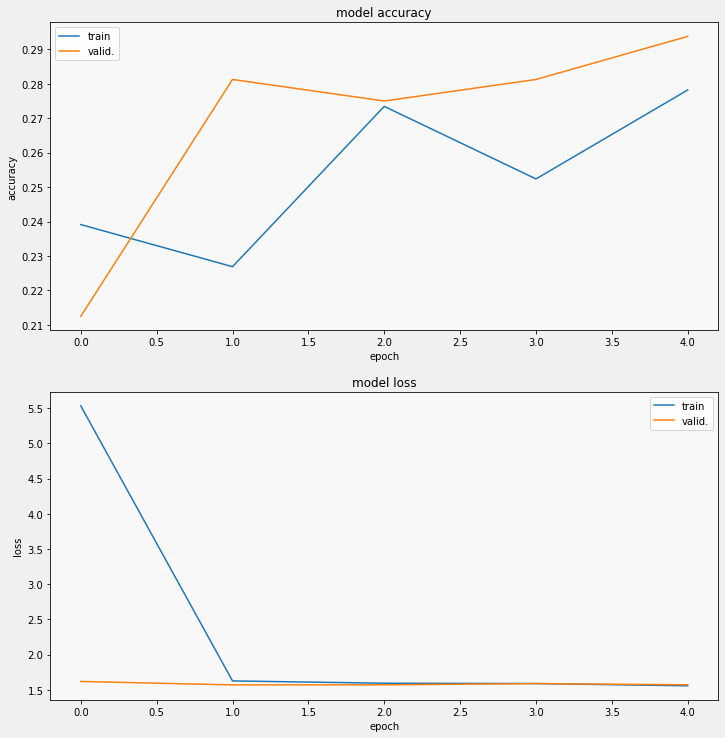

In [167]:
hist=pd.read_pickle(BUCKET+"/history-mirroredStrategy-128batchsize.pkl")
display_training_curves(hist['accuracy'], hist['val_accuracy'], 'accuracy', 211)
display_training_curves(hist['loss'], hist['val_loss'], 'loss', 212)
clusterConfig=pd.read_pickle(BUCKET+"/clusterConfiguration-mirroredStrategy-128batchsize.pkl")
print(clusterConfig)
trainTime=pd.read_pickle(BUCKET+"/trainingTime-mirroredStrategy-128batchsize.pkl")
print(trainTime)

# Section 3. Theoretical discussion

## Task 5: Discussion in context. (20%)

In this task we refer to two ideas that are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
-	Smith, S. L., Kindermans, P. J., Ying, C., & Le, Q. V. (2018). [Don't Decay the Learning Rate, Increase the Batch Size.](https://openreview.net/pdf?id=B1Yy1BxCZ) In ICLR (no pagination).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given task. 
Smith et al (2018) introduce the concept of varying the batch size during the training of neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) discuss general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 


# Final cleanup

Once you finished all the tasks and your report, and submitted the ipynb and pdf file on Moodle, you can delete the created storage bucket and project to avoid spending any more of your free credit.

In [6]:
!gsutil -m rm -r $BUCKET/*
!gsutil rb $BUCKET
!gcloud projects delete $PROJECT

Removing gs://bigdataprojectpabloquinoa-storage/clusterConfiguration-mirroredStrategy-128batchsize.pkl#1591545707352475...
Removing gs://bigdataprojectpabloquinoa-storage/trainingTime-mirroredStrategy-128batchsize.pkl#1591545706091117...
Removing gs://bigdataprojectpabloquinoa-storage/clusterConfiguration-mirroredStrategy-64batchsize.pkl#1591545287945318...
Removing gs://bigdataprojectpabloquinoa-storage/history.pkl#1591536884961490...
Removing gs://bigdataprojectpabloquinoa-storage/clusterConfiguration.pkl#1591536887478291...
Removing gs://bigdataprojectpabloquinoa-storage/history-mirroredStrategy-128batchsize.pkl#1591545704827425...
Removing gs://bigdataprojectpabloquinoa-storage/trainingTime-mirroredStrategy-64batchsize.pkl#1591545286655311...
Removing gs://bigdataprojectpabloquinoa-storage/history-mirroredStrategy-64batchsize.pkl#1591545285375694...
Removing gs://bigdataprojectpabloquinoa-storage/trainingTime.pkl#1591536886195556...
Removing gs://bigdataprojectpabloquinoa-storage/f